# Bachelor Thesis 

## Credit risk modelling: an empirical analysis on Probability of Default (PD) estimation 
solution provided by: **Daniel Travaglia**

## Draft of the outline of the notebook

0. [r] Introduction: frame the problem
1. [r] Prerequisites: set up the environment
2. [r] Retrieve and describe the dataset
3. [r] Discover and visualize data for reacher insights 
4. [x] PD Calibration
5. PD Modelling - Machine Learning Pipelines:
    - [r] Model (1): Logistic Regression Model
        1. Data prepocessing and model definition
        2. Cross validation for better evaluation and fine-tuning to obtain optimal model parameters
        3. Retrieve the optimal model 
    - [x] Model (2): Ensemble Model (Gradient Boosting)
        1. Data preprocessing and model definition
        2. Cross validation for better evaluation and fine-tuning to obtain optimal model parameters
        3. Retrieve the optimal model
6. [x] Get the best model (metric comparison)
7. [x] Evaluate the system on the test set and plot the results
8. [x] Conclusions
9. (Bonus) Further improvements

# (0) Introduction: frame the problem

# (1) Set up the environment

This section is  the core libraries that will be used throughout the entire notebook are loaded. 
* NumPy and Pandas provide the fundamental tools to handle datasets and arrays.
* Skikit-learn provides amazing tools that simplify quite significantly the modelling part.
* Last but not least, matplotlib and seaborn are amazing libraries that enables to create effective visualizations to explore the data even further.

### Retrieving libraries

In [335]:
# Data manipulation ML libraries
import numpy as np 
import pandas as pd
from scipy import stats
from scipy.stats import norm
from scipy.stats import foldnorm

# Ignore irrelevant warnings to make the code nicer!
import warnings
warnings.filterwarnings('ignore')

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 

# database libraries
import pyodbc                       

# graphic settings
# Make things work smoother for plots
%matplotlib inline
# Se the backend of plotting to matplotlib
pd.options.plotting.backend = 'matplotlib'
# Set up the seaborn-visualization to get a better experience
# sns.set(color_codes=True)
sns.set(
    # style="white", 
    # palette=cmap, 
    color_codes=True, 
    font_scale=1.1
)

### Loading data settings

In [55]:
## CSV
# Counterparty data path
cp_path = "data\counterparty.csv"
# Counterparty loans data path
loans_path = "data\counterparty_loans.csv"

# (2) Retrieve and describe the dataset

Goal of this section is to provide information on the structure of the dataset used for the analysis. To begin with, a high-level description of the two tables will be given. Later in the analysis, we will take a closer look at the data and conduct a sanity check to see whether the information we are provided with is consistent and in line with expectations.

## (2.1) Loading the datasets

The data is spread across 2 different tables:

* **Counterparty**: dataset that contains some general characteristics and information regarding the counterparties 
* **Loans**: dataset that provides relevant information on the loans issed by financial istitutions.

Before proceeding, it is important to clarify that each counterparty from the "counterparty" table is associated with one (and only one) loan from the "loans" table. This means that there is a one-to-one mapping between counterparties and loans, which is not usually corresponding to a classic scenario within a financial or any other credit lending istitution that wish to model for some credit risk metrics. Indeed, the latters usually make use of time-series data, which often provide a credit history of all the accounts (i.e. each financial instruments that the financial istitution can provide to the client) for multiple periods. In this context, the scenario is completely different: we are dealing with a panel data. In particular, each observation represents a snapshot of the credit availability associated with a counterparty at a certain point in time, a characteristic that is shared among all the observations. In other words, we get rid of the time dimension. Clearly, this translates into two different approaches to estimate probability of default. A financial istitution might want to model the PD ("probability of default") taking into account time-dependent factors (e.g. market risk factor, macroeconomic scenarios and so om). However, the nature and the structure of the data force us in keeping things simple with a much less ambitious objective: we would like to estimate the proability that a counteparty default on its obligations by only taking into consideration its characteristics and that of the financial obligation, namely disregarding everything (e.g. market risk, FX risk, economic condition, etc..) besides credit risk related factors.

In [56]:
# Retrieving counterparty data
df_cp = pd.read_csv(cp_path)
# Retrieving counterparty loans data
df_loans = pd.read_csv(loans_path)

# make sure the file is loaded
assert not (df_cp.empty and df_loans.empty)

## (2.2) A first glence at the data

In this section we will explore the counterparty table, its shape and a brief analysis on the observations to verify consistency in the data. We will then proceed with the same type of analysis on the loan table and, eventually, we will merge the two dataset to retrieve additional insights with a combined explanatory analysis.

### (2.2.1) Counterparty dataset

In [57]:
df_cp.shape

(32581, 7)

The counterparty dataset contains 32581 observations, each of which represents a specific counterparty. The latters are described is then described by 7 different features. Let's now dig a little bit more to discover what type of information we have on the counterparties

In [58]:
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_cp                       32581 non-null  int64  
 1   cp_age                      32581 non-null  int64  
 2   cp_income                   32581 non-null  int64  
 3   cp_home_ownership           32581 non-null  object 
 4   cp_emp_length               31686 non-null  float64
 5   cp_person_default_on_file   32581 non-null  object 
 6   cp_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 1.7+ MB


The dataset provides the following information regarding the counterparties: 
* Age: age of the person 
* Income: personal income in $ (dollars)
* Home ownership: whether the person owns a house or it is supplied with in any other ways (RENT, MORTGAGE, ... or other financial instruments)
* Employment length: how long (in years) the person has been employed
* Person default on file: whether in the past the person has already defaulted or not on an obligation
* Credit history length: length of the credit grant in years up until now

Let's clarify some points that emerge from this simple table

1. It can be easily noticed that some observations for "employment length" variable are missing. This is a situation that must be carefully handled before proceeding into modelling.

2. We want to turn some variables (e.g. home ownership and person default on file) into categorical features. Such procedure will simplify our analysis quite significantly and it will be specially relevant for the modelling part.

At this point you might wonder: how's the data looks like?

## Get rid of missing values for employment length


In [59]:
# Drop missing values
df_cp.isna().sum()

id_cp                           0
cp_age                          0
cp_income                       0
cp_home_ownership               0
cp_emp_length                 895
cp_person_default_on_file       0
cp_person_cred_hist_length      0
dtype: int64

In [60]:
# Get rid of 895 observations from counterparties table
df_cp = df_cp.dropna()

In [61]:
df_cp.head()

,id_cp,cp_age,cp_income,cp_home_ownership,cp_emp_length,cp_person_default_on_file,cp_person_cred_hist_length
0,1,22,59000,RENT,123.0,Y,3
1,2,21,9600,OWN,5.0,N,2
2,3,25,9600,MORTGAGE,1.0,N,3
3,4,23,65500,RENT,4.0,N,2
4,5,24,54400,RENT,8.0,Y,4


It seems that we have relevant information regarding the counterparties. It is worth discussing on the following point before proceeding: 

* Presence of (invalid) outliers: the first observation is characterized by a value for "employment length" that is clearly out of range: how could a person be employed for 123 years? And how would it be possible for a 22 years old person in the first place?

* The issue highlighted above might have further implications which are probably worth discussing before proceeding: we already hightlighted how it is important in a analytical project to have a rough idea of the context and to know what each variable represents. If combined with a proper explanatory analysis, it is possible to spot most of the inconsistencies in the data (i.e. bad/invalid outliers). However, this might not be enough: the counterparty could provide false information with the aim of increasing the likelihood to obtain the credit. Such setting is usually worst in presence of asymmetric information: the fact that one party is more informed that the other party might generate some inefficencies in the lending market. This topic will be subject of discussion for the last chapter of this paper.

Let's retrieve some statistics to see whether there is presence of other inconsistencies within the data.

In [62]:
df_cp.describe()

,id_cp,cp_age,cp_income,cp_emp_length,cp_person_cred_hist_length
count,31686.000000,31686.000000,3.168600e+04,31686.000000,31686.000000
mean,16328.990374,27.747302,6.669188e+04,4.789686,5.809316
std,9394.590983,6.360283,6.242729e+04,4.142630,4.060867
min,1.000000,20.000000,4.000000e+03,0.000000,2.000000
25%,8209.250000,23.000000,3.939700e+04,2.000000,3.000000
50%,16314.500000,26.000000,5.600000e+04,4.000000,4.000000
75%,24479.750000,30.000000,8.000000e+04,7.000000,8.000000
max,32581.000000,144.000000,6.000000e+06,123.000000,30.000000


This table allows us to easily identify the incosistencies mentioned above: the maximum employment length among all observations is 123 years. In addition, the maximum registred age for a counterparty is 144 years. Such values will definetely require further investigation and manipulation to obtain a dataset on top of which we can work on. There seems to be also unemployed counterparties who took up a loan which might require further analysis. All the other numbers seem to be reasonably acceptable.

### Removing inconsistencies - Counterparty
From counterparties that age above 100 and those that have more than 50 years of employment

In [63]:
# Retrieve the number of values which are not reasonable
df_invalid = df_cp[(df_cp.cp_age > 100) | (df_cp.cp_emp_length > 50)]
# Dropping absurd values from the dataset
df_cp.drop(index=df_invalid.index,inplace=True)

### Univariate analysis - Counterparty

This section make use of visualization tools: particular attention will be given to the distribution of the data and whether it is possible to retrieve additional insights

In [64]:
# Create a copy for analysis purposes
df_cp_analysis = df_cp.copy().drop(columns=["id_cp"])

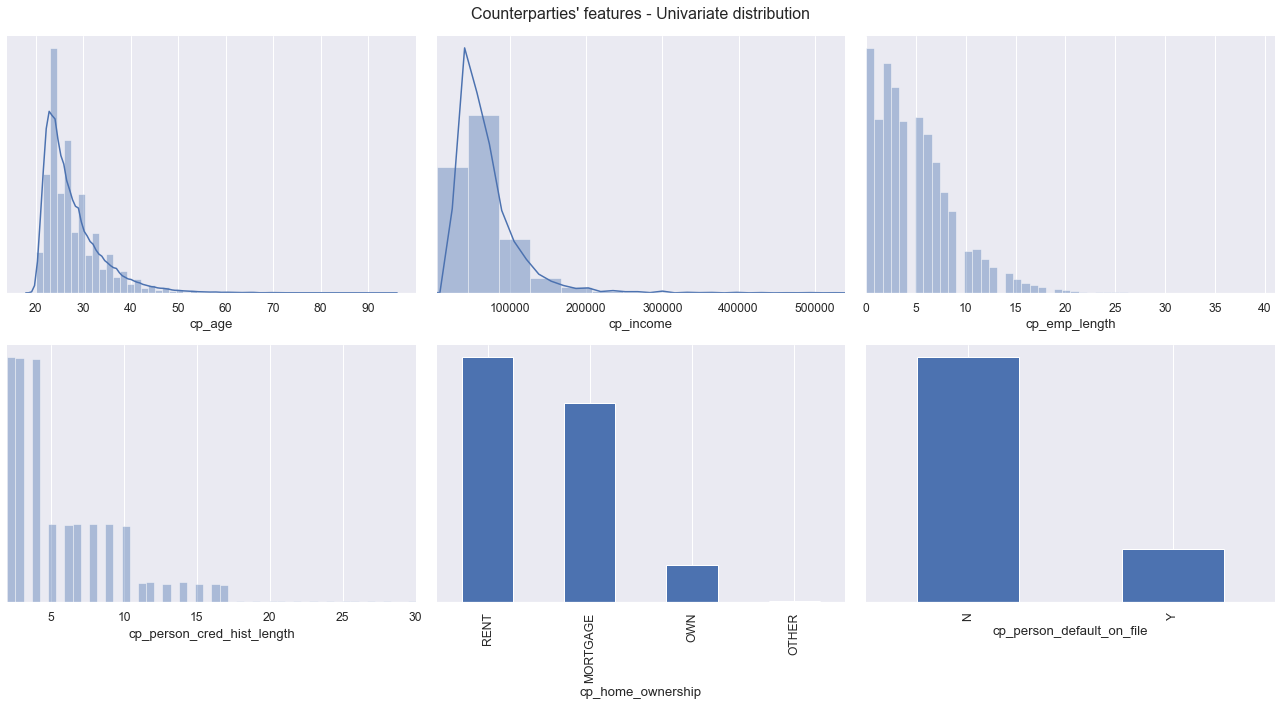

In [65]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.despine(left=True)

# Univariate distributions

# (1) Age distribution (with no density estimation)
fig_age = sns.distplot(df_cp_analysis.cp_age,kde=True,ax=axes[0,0])
# fig_age.axis(xmin=df_cp_analysis.cp_age.min() - 10, xmax=df_cp_analysis.cp_age.max() + 10)

# (2) Income distribution (with density estimation)
fig_income = sns.distplot(df_cp_analysis.cp_income,kde=True,ax=axes[0,1])
fig_income.axis(xmin=df_cp_analysis.cp_income.min(), xmax=df_cp_analysis.cp_income.max() - 1.5e6)

# (3) Employment length distribution (with density estimation)
fig_emp_leng = sns.distplot(df_cp_analysis.cp_emp_length,kde=False,ax=axes[0,2])
fig_emp_leng.axis(xmin=df_cp_analysis.cp_emp_length.min(), xmax=df_cp_analysis.cp_emp_length.max())

# (4) Credit history length distribution (with no density estimation)
fig_cr_hist = sns.distplot(df_cp_analysis.cp_person_cred_hist_length,kde=False,ax=axes[1,0])
fig_cr_hist.axis(xmin=df_cp_analysis.cp_person_cred_hist_length.min(), xmax=df_cp_analysis.cp_person_cred_hist_length.max())

# (5) Home ownership data 
fig_home = df_cp_analysis.groupby(["cp_home_ownership"])["cp_home_ownership"]\
                            .count()\
                            .sort_values(ascending=False)\
                            .plot(kind="bar",ax=axes[1,1])

# (6) Whether the counterparty defaulted or not in the past 
fig_def = df_cp_analysis.groupby(["cp_person_default_on_file"])["cp_person_default_on_file"]\
                            .count()\
                            .sort_values(ascending=False)\
                            .plot(kind="bar",ax=axes[1,2])

f.suptitle("Counterparties' features - Univariate distribution", fontsize=16)

plt.setp(axes, yticks=[])
plt.tight_layout()

The image above includes the univariate distribution of all the numerical features of the counterparty dataset as well as some representation for all the categorical features. Plenty of things stand out here:

* As we have already noticed, almost the entire set of counterparties is represented by people between their 20s and their 40s. As expected, the age distribution has an impact also on all the other variables of this table. 

* Lower age should be the reason for having shorter employment periods and credit history length. In particular, there seems to be a great portion of unemployed people as well as a very large amount of counterparties with little-to-none credit history. Intuitevely, unemployment should have high impact on the assessment of the PD of a counterparty. 

* A very small number of counterparties owns a house, while the majority is either renting or on a mortgage. The latter would proably need further analysis, as these people already took upon themselves additional debt that should be repaid. Hence, the question here becomes whether these individuals have enough liquidity inflows to sustain another obligation for an extended period of time.

* The most representative class of counterparties have not defaulted on an obligation in the past. This information should turn out to be of massive importance when factored in the PD model.

* Lastly, the income distribution is skewed to the left and the plot against a gaussian density seems to confirm this hypothesis. Why is this important? Well, the relevance of having normally distributed features is due to the fact that several statistical tests (e.g. t-statistic) take by assumption normally distributed data. However, as we will see later, since we will have to model a binary dependent variable (i.e. can take either value 0 or 1), the models that will be used do not have any assumptions about normally distributed explanatory variables.

Before proceeding with the dataframe that describe the loans, let's have a look at some of the points mentioned above individually.

### Discretizing among unemployed and employed people
The employment situation of a counterparty provides with additional information on the likelihood that the obligator will meet its obligations and sustain the repayments. 
A great proportion of counterparties in the dataset is currently unemployed and our economic intuition would suggest to deepen the analysis into this category. Moreover, to increase the model accuracy and reduce the uncertainty, it might be useful to discretize and categorize the observations based on the employment time-horizon. The split will be based on the quantile of the distribution of the feature in such a way that there is an equal number of observations across all the 4 defined categories: 

- unemployed
- employed - junior
- employed - middle
- employed - senior

In [66]:
# (1) Retrieve unemployed counterparty dataset
df_cp_unemp = df_cp_analysis[df_cp_analysis.cp_emp_length == 0]

In [67]:
# (2) Get some statistics
print(f"{(df_cp_unemp.shape[0] / df_cp_analysis.shape[0]) * 100:.2f}% of counterparties is unemployed") 

12.96% of counterparties is unemployed


In [68]:
# (3) Discretization

# (3.1) Make sure to have consistency in the data (cap between 0 and 50)
df_cp_analysis.cp_emp_length.clip(0.0, 50.0, inplace=True)

# (3.2) Define bins to split the categories
# emp_bins = pd.IntervalIndex.from_tuples([(-0.001,0),(0,3),(3,6),(6,df_cp_analysis.cp_emp_length.max())])

# (3.2) Define the labels
emp_labels = ["UNEMPLOYED","JUNIOR","MIDDLE","SENIOR"]

# (3.3) Retrieve also employed CP
df_cp_emp = df_cp_analysis[df_cp_analysis.cp_emp_length != 0]

# (3.4) Perform the split on employed CP (3 splits)
df_cp_emp["cp_emp_title"] = pd.qcut(df_cp_emp.cp_emp_length,q=3,labels=emp_labels[1:])

# (3.5) Perform the split on unemployed CP (1 split)
df_cp_unemp["cp_emp_title"] = pd.qcut(df_cp_unemp.cp_emp_length,q=1,labels=[emp_labels[0]])

In [69]:
# (4) Combine the datasets
df_cp_emp_unemp = pd.concat([df_cp_unemp,df_cp_emp])
# Get the result
df_cp_emp_unemp.head()

,cp_age,cp_income,cp_home_ownership,cp_emp_length,cp_person_default_on_file,cp_person_cred_hist_length,cp_emp_title
16,23,120000,RENT,0.0,N,4,UNEMPLOYED
23,24,10980,OWN,0.0,N,3,UNEMPLOYED
27,23,11000,OWN,0.0,N,3,UNEMPLOYED
45,26,300000,MORTGAGE,0.0,N,3,UNEMPLOYED
49,26,89028,RENT,0.0,N,3,UNEMPLOYED


In [70]:
# (5) Merge the information into the original dataset

# (5.1) Drop employment length from the original dataset
df_cp.drop(columns=["cp_emp_length"],inplace=True)

# (5.2) Merge original dataset with employment status
df_cp = pd.merge(df_cp,df_cp_emp_unemp["cp_emp_title"],left_index=True,right_index=True)

# (5.3) How does the df looks like?
df_cp.head()

,id_cp,cp_age,cp_income,cp_home_ownership,cp_person_default_on_file,cp_person_cred_hist_length,cp_emp_title
1,2,21,9600,OWN,N,2,MIDDLE
2,3,25,9600,MORTGAGE,N,3,JUNIOR
3,4,23,65500,RENT,N,2,MIDDLE
4,5,24,54400,RENT,Y,4,SENIOR
5,6,21,9900,OWN,N,2,JUNIOR


### Counterparty credit history
The credit history of a person can tell much about the financials of a person and can serve also as a good indicator of counterparty's ability to sustain repayments. Once again, the way this variable is represented might not tell much, but if discretized into multiple groups, the feature might return additional insights in the multivariate analysis and also increase the model performances. It makes sense to have 3 representations based on the period length: "short", "medium", "long"

In [71]:
# Discretization

# (1) Cap the variable
df_cp_analysis.cp_person_cred_hist_length.clip(0.0, 100.0, inplace=True)
# (2) Define the labels 
cred_length_labels = ["SHORT","MEDIUM","LONG"]
# (3) Discretize the variable
df_cp_analysis["cp_cred_period"] = pd.qcut(df_cp_analysis.cp_person_cred_hist_length,q=3,labels=cred_length_labels)
# (4) Represent the results
df_cp_analysis.head(5)

,cp_age,cp_income,cp_home_ownership,cp_emp_length,cp_person_default_on_file,cp_person_cred_hist_length,cp_cred_period
1,21,9600,OWN,5.0,N,2,SHORT
2,25,9600,MORTGAGE,1.0,N,3,SHORT
3,23,65500,RENT,4.0,N,2,SHORT
4,24,54400,RENT,8.0,Y,4,MEDIUM
5,21,9900,OWN,2.0,N,2,SHORT


In [72]:
# Drop the original variable from the dataset
df_cp.drop(columns=["cp_person_cred_hist_length"],inplace=True)

# Merge with the original dataset
df_cp = pd.merge(df_cp,df_cp_analysis["cp_cred_period"],left_index=True,right_index=True)

# How does the data looks like
df_cp.head()

,id_cp,cp_age,cp_income,cp_home_ownership,cp_person_default_on_file,cp_emp_title,cp_cred_period
1,2,21,9600,OWN,N,MIDDLE,SHORT
2,3,25,9600,MORTGAGE,N,JUNIOR,SHORT
3,4,23,65500,RENT,N,MIDDLE,SHORT
4,5,24,54400,RENT,Y,SENIOR,MEDIUM
5,6,21,9900,OWN,N,JUNIOR,SHORT


### Discretizing age

Trying to discritize also age, although it might not be a good idea given the very limited range of unique values for this variable and the distribution which is approximately normal

In [73]:
# # Discretization

# (1) Cap the variable
df_cp_analysis.cp_age.clip(0.0, 100.0, inplace=True)
# (2) Define the labels 
age_labels = ["YOUNGER","OLDER"] 
# (3) Discretize the variable
df_cp_analysis["cp_age_bucket"] = pd.qcut(df_cp_analysis.cp_age,q=2,labels=age_labels)
# (4) Represent the results
df_cp_analysis.head(5)

,cp_age,cp_income,cp_home_ownership,cp_emp_length,cp_person_default_on_file,cp_person_cred_hist_length,cp_cred_period,cp_age_bucket
1,21,9600,OWN,5.0,N,2,SHORT,YOUNGER
2,25,9600,MORTGAGE,1.0,N,3,SHORT,YOUNGER
3,23,65500,RENT,4.0,N,2,SHORT,YOUNGER
4,24,54400,RENT,8.0,Y,4,MEDIUM,YOUNGER
5,21,9900,OWN,2.0,N,2,SHORT,YOUNGER


In [74]:
# Drop the original variable from the dataset
df_cp.drop(columns=["cp_age"],inplace=True)

# Merge with the original dataset
df_cp = pd.merge(df_cp,df_cp_analysis["cp_age_bucket"],left_index=True,right_index=True)

# How does the data looks like
df_cp.head()

,id_cp,cp_income,cp_home_ownership,cp_person_default_on_file,cp_emp_title,cp_cred_period,cp_age_bucket
1,2,9600,OWN,N,MIDDLE,SHORT,YOUNGER
2,3,9600,MORTGAGE,N,JUNIOR,SHORT,YOUNGER
3,4,65500,RENT,N,MIDDLE,SHORT,YOUNGER
4,5,54400,RENT,Y,SENIOR,MEDIUM,YOUNGER
5,6,9900,OWN,N,JUNIOR,SHORT,YOUNGER


### Mortgages and rents - Additional counterparty's debt
As some counterparties show ownership of a house, some other are either on a rent or on a mortgage, which represents frequent outgoings that might cause financial hardship and therefore, increase the likelihood that the obligator would not meet the obligations.

In [75]:
# Retrieve unemployement rate
df_cp_rent_mort = df_cp_analysis[(df_cp_analysis.cp_home_ownership == "MORTGAGE") | (df_cp_analysis.cp_home_ownership == "RENT")]["cp_home_ownership"].count() / df_cp_analysis.shape[0]
# Print out the number
print(f"{df_cp_rent_mort * 100:.2f}% of counterparties are either on a mortgage or a rent contract")

92.05% of counterparties are either on a mortgage or a rent contract


This percentage is impressive and as such, it would be interesting to dive deeper into this pool of counterparties and inspect for additional information.

## (2.2.2) Loans dataset

Let us now focus on loan dataset, which provides information regarding individual loans that were given to counterparties by means of a financial istitution

In [76]:
# Dropping useless features for analysis and NAN values (for interest rate)
df_loans_analysis = df_loans.drop(columns=["id_loan"])
df_loans_analysis.shape

(32581, 7)

This dataset has the same number of observations as the counterparties' dataset. This give evidences of a one-to-one relationship between counterparties and loans (i.e. 1 counterparty = 1 loan). Moreover, each loan is described by 6 different features (the 7th is defined as a foreign key to match observations between the two datasets)

In [77]:
df_loans_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_intent          32581 non-null  object 
 1   loan_grade           32581 non-null  object 
 2   loan_amount          32581 non-null  int64  
 3   loan_int_rate        29465 non-null  float64
 4   loan_status          32581 non-null  int64  
 5   loan_percent_income  32581 non-null  float64
 6   fk_cp                32581 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 1.7+ MB


The following information on loans are provided:

* *Loan intent*: reason to ask for a loan

* *Loan grade*: the rating associated with the loan and the relative counterparty. This variable should give us insights on the risk associated to the loan, which is usually driven by the underlying characteristics of the financial instrument (i.e. the loan) as well as the counterparty's characteristics.

* *Loan amount*: the amount of the loan

* *Loan interest rate*: the interest rate associated with the loan.

* *Loan status*: whether the counterparty has defaulted or not on such loan (1 is defaulted, 0 is not). This is going to be our dependent variable: we want to estimate the probability that a customer is going to default given certain characteristics on the loans (loans dataset) along with characteristics on the counterparty itself (counterparty dataset)

* *Loan percent income*: the proportion of the loan amount with respect to the income of the relative counterparty 

It seems that a huge amount of observations do not have information on the interest rate applied to the loan. Being an indicator of how risky the investment is, one possibility to get rid of these missing values could be represented by applying a map between ratings and interest rates and replace them based on a random sampling within the range of the interest rate for a specific category (i.e. loan_intent) and for the rating characterizing such loan (i.e. loan_grade). Through such procedure however, there is the risk of injecting biased information in the data that might lead eventually to have a model with bad predictiory power. Dropping these observations seems to be way to go in this case. [TODO -> ask Lijoi about this possibility of not dropping variables]

In [78]:
# Dropping observations with NA interest rates
df_loans_analysis.dropna(inplace=True)

In [79]:
df_loans_analysis.head()

,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income,fk_cp
0,PERSONAL,D,35000,16.02,1,0.59,1
1,EDUCATION,B,1000,11.14,0,0.10,2
2,MEDICAL,C,5500,12.87,1,0.57,3
3,MEDICAL,C,35000,15.23,1,0.53,4
4,MEDICAL,C,35000,14.27,1,0.55,5


The first observations do not signal any particular concern on the data. Let's see whether this is also confirmed by the statistics.

In [80]:
df_loans_analysis.describe()

,loan_amount,loan_int_rate,loan_status,loan_percent_income,fk_cp
count,29465.000000,29465.000000,29465.000000,29465.000000,29465.000000
mean,9584.744612,11.011695,0.219379,0.170110,16255.430171
std,6316.272282,3.240459,0.413833,0.106879,9398.868732
min,500.000000,5.420000,0.000000,0.000000,1.000000
25%,5000.000000,7.900000,0.000000,0.090000,8101.000000
50%,8000.000000,10.990000,0.000000,0.150000,16261.000000
75%,12250.000000,13.470000,0.000000,0.230000,24394.000000
max,35000.000000,23.220000,1.000000,0.830000,32581.000000


All the numerical features seem reasonably within the expected range. Apparently, there are some observations that show a loan amount w.r.t. the income of the counterparty equal to 0, despite the minumum loan amount being equal to 500. This signals presence of inconsistencies that should be carefully analyzed and handled as soon as we have a comprehensive view of each loan with its respective counterparty. Moreover, few things can already be highlighted here before proceeding with the analysis:

1) As we have seen before, "loan status" is a binary feature: it only takes values 1 or 0 depending on whether the counterparty already defaulted or not on the loan respectively. The average value of the distribution of this feature is skewed towards 0, which suggests that we are provided with an unbalanced set. In other words, there is presence of more non-defaulting loans than the defaulted ones. Hence, our model should be more accurate in predicting non-defaulted loans than their counterparts due to much higher number of observations.

2) Suspicious numbers in the "loan over income" feature will be subject of later analysis. However, the mean and the standard deviation of the distribution of this feature suggest that the amount of the loans is just a small percentage of the overall counterparty's income. This might be a good reason for which we have many more non-defaulting loans in the dataset, but such assumption would definetely require a much closer look at the data, as counterparty's financial inflows/outflows play a more significant role for this purpose.

3) The average interest rate on loans is pretty high (even respect to the distribution of the loan amounts). Such finding would require a further assessment on the counterparty's financial inflows and outflows to see whether these numbers can be sustained in the long-term by counterparties. 

This analysis should be further supported with some visualizations and statistics to provide richer insights in an attempt to discover hidden patterns. This will be the subject of the next chapter.

### Data inconsistencies in "loan_percent_income"
The variable "loan_percent_income" describes how much of the loan amount can be explained by the counterparty's income. Potential inconsistencies were already spotted previously in the analysis, and since this feature can be easily calculated it is convenient to correct them whenever needed.

In [81]:
## Check whether the hypothesis is true: loan_percent_income can be computer by dividing loan amount and income

# (1) Retrieve the dataframe to work on
df_loans_cp_amount_income = pd.merge(df_loans_analysis[df_loans_analysis.loan_percent_income != 0],df_cp,how="inner",left_index=True,right_index=True)
# (2) Store the calculated variable 
df_loans_cp_amount_income["loan_percent_income_calc"] = round(df_loans_cp_amount_income.loan_amount / df_loans_cp_amount_income.cp_income, 2) 
# (3) Store the differences between the calculated variable and the original one
df_loans_cp_amount_income["loan_percent_income_diff"] = abs(df_loans_cp_amount_income["loan_percent_income_calc"] - df_loans_cp_amount_income["loan_percent_income"]) 
# (3) Retrieve the observations that show incosistencies
df_loans_cp_amount_income_diff = df_loans_cp_amount_income[df_loans_cp_amount_income["loan_percent_income_diff"] != 0]
# (4) Print how many they are
print(f"Number of miscalculations: {df_loans_cp_amount_income_diff['loan_percent_income_diff'].count()}")
# (5) Display data
df_loans_cp_amount_income_diff.sort_values(by=["loan_percent_income_diff"],ascending=False).head()

Number of miscalculations: 903


,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income,fk_cp,id_cp,cp_income,cp_home_ownership,cp_person_default_on_file,cp_emp_title,cp_cred_period,cp_age_bucket,loan_percent_income_calc,loan_percent_income_diff
4,MEDICAL,C,35000,14.27,1,0.55,5,5,54400,RENT,Y,SENIOR,MEDIUM,YOUNGER,0.64,0.09
11873,MEDICAL,D,35000,16.89,1,0.49,11874,11874,60350,MORTGAGE,N,MIDDLE,SHORT,YOUNGER,0.58,0.09
24150,MEDICAL,D,27050,14.54,1,0.42,24151,24151,54400,MORTGAGE,N,JUNIOR,MEDIUM,OLDER,0.50,0.08
11253,MEDICAL,D,30000,16.49,1,0.45,11254,11254,56403,MORTGAGE,N,SENIOR,SHORT,YOUNGER,0.53,0.08
30936,MEDICAL,F,25000,18.09,1,0.39,30937,30937,54400,MORTGAGE,N,SENIOR,LONG,OLDER,0.46,0.07


There seems to be misalignments between the variable stored and the one calculated for some observations.   

In [82]:
## Check whether loan_percent_income = 0 is indeed an inconsistency here

# (1) Retrieve potential inconsistencies
df_loans_invalid = df_loans_analysis[df_loans_analysis.loan_percent_income == 0]

# (2) Merge with counterparty dataframe
df_loans_cp_invalid = pd.merge(df_loans_invalid,df_cp,how="inner",left_index=True,right_index=True)

# (3) Print how many they are
print(f"Number of inconsistencies: {df_loans_invalid.shape[0]}")

# (4) Display the data
df_loans_cp_invalid.head()

Number of inconsistencies: 8


,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income,fk_cp,id_cp,cp_income,cp_home_ownership,cp_person_default_on_file,cp_emp_title,cp_cred_period,cp_age_bucket
17834,PERSONAL,B,2000,9.99,0,0.0,17835,17835,948000,MORTGAGE,N,SENIOR,MEDIUM,OLDER
18917,PERSONAL,C,1800,13.48,0,0.0,18918,18918,510000,RENT,N,JUNIOR,MEDIUM,OLDER
27877,HOMEIMPROVEMENT,A,2500,7.43,0,0.0,27878,27878,522000,MORTGAGE,N,SENIOR,LONG,OLDER
30049,VENTURE,C,8450,12.29,0,0.0,30050,30050,2039784,RENT,Y,UNEMPLOYED,LONG,OLDER
31916,HOMEIMPROVEMENT,A,1000,8.94,0,0.0,31917,31917,780000,MORTGAGE,N,JUNIOR,LONG,OLDER


On the other hand, there are also few observations that show inconsistencies as "loan_percent_income" is 0, when loan amount and counterparty income, taken together, show different results. Hence, it might be the case to recalculate the entire column to include all observations that were missed out. This adjustment should lead to a more accurate estimation if the variable turns out to be important for modelling.

In [83]:
## Replace column with calculation-based (loan_amount/cp_income) calculation

# Merge with counterparty dataset
df_loans_cp_analysis = pd.merge(df_loans_analysis,df_cp,how="inner",left_index=True,right_index=True)

# Recalculate entire column and replace the original value
df_loans_cp_analysis.loan_percent_income = round(df_loans_cp_analysis.loan_amount / df_loans_cp_analysis.cp_income, 3)

# Get a few observations to inspect number consistency
df_loans_cp_analysis.head()

,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income,fk_cp,id_cp,cp_income,cp_home_ownership,cp_person_default_on_file,cp_emp_title,cp_cred_period,cp_age_bucket
1,EDUCATION,B,1000,11.14,0,0.104,2,2,9600,OWN,N,MIDDLE,SHORT,YOUNGER
2,MEDICAL,C,5500,12.87,1,0.573,3,3,9600,MORTGAGE,N,JUNIOR,SHORT,YOUNGER
3,MEDICAL,C,35000,15.23,1,0.534,4,4,65500,RENT,N,MIDDLE,SHORT,YOUNGER
4,MEDICAL,C,35000,14.27,1,0.643,5,5,54400,RENT,Y,SENIOR,MEDIUM,YOUNGER
5,VENTURE,A,2500,7.14,1,0.253,6,6,9900,OWN,N,JUNIOR,SHORT,YOUNGER


## Univariate Analysis - Loans

In [84]:
# Columns to be explored
cols = ['loan_intent', 'loan_grade', 'loan_amount', 'loan_int_rate','loan_status', 'loan_percent_income']
# Define the dataframe for univariate analysis
df_loans_analysis = df_loans_cp_analysis[['loan_intent', 'loan_grade', 'loan_amount', 'loan_int_rate','loan_status', 'loan_percent_income']].copy()
# Retrieve columns
df_loans_analysis.head()

,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income
1,EDUCATION,B,1000,11.14,0,0.104
2,MEDICAL,C,5500,12.87,1,0.573
3,MEDICAL,C,35000,15.23,1,0.534
4,MEDICAL,C,35000,14.27,1,0.643
5,VENTURE,A,2500,7.14,1,0.253


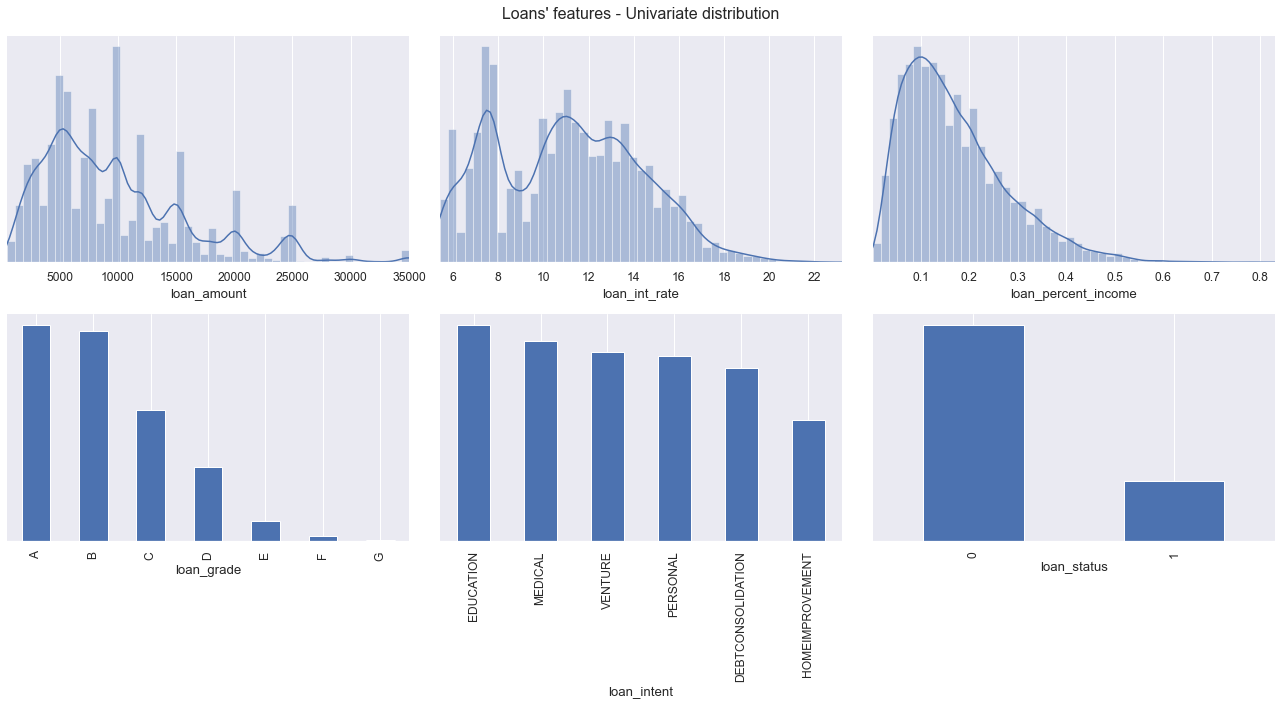

In [85]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.despine(left=True)

# Univariate distributions

# (1) Amount of the loan
fig_amount = sns.distplot(df_loans_analysis.loan_amount,kde=True,ax=axes[0,0])
fig_amount.axis(xmin=df_loans_analysis.loan_amount.min(), xmax=df_loans_analysis.loan_amount.max())

# (2) Interest rate attached to the loan
fig_int_rate = sns.distplot(df_loans_analysis.loan_int_rate,kde=True,ax=axes[0,1])
fig_int_rate.axis(xmin=df_loans_analysis.loan_int_rate.min(), xmax=df_loans_analysis.loan_int_rate.max())

# (3) Loan amount over income of the counterparty
fig_lpi = sns.distplot(df_loans_analysis.loan_percent_income,kde=True,ax=axes[0,2])
fig_lpi.axis(xmin=df_loans_analysis.loan_percent_income.min(), xmax=df_loans_analysis.loan_percent_income.max())

# (4) Rating attached to the loan 
fig_grade = df_loans_analysis.groupby(["loan_grade"])["loan_grade"].count().sort_values(ascending=False).plot(kind="bar",ax=axes[1,0])

# (5) Counterparty intent to go for a loan
fig_intent = df_loans_analysis.groupby(["loan_intent"])["loan_intent"].count().sort_values(ascending=False).plot(kind="bar",ax=axes[1,1])

# (6) Whether the counterparty defaulted or not on the loan 
fig_status = df_loans_analysis.groupby(["loan_status"])["loan_status"].count().sort_values(ascending=False).plot(kind="bar",ax=axes[1,2])

f.suptitle("Loans' features - Univariate distribution", fontsize=16)

plt.setp(axes, yticks=[])
plt.tight_layout()

The image above shows the univariate distributions of the features describing the loans. Although we have already introduced some of the key takeaways, there are some additional aspects that we might want to take into consideration before proceeding:

* The loan amount is mostly concentrated around 5-10K, which is a relatively low number with respect to the income of counterparties. This aspect is indeed captured by the distribution of the "loan_percent_income", but it would also be interesting to plug-in the interest rate in the equation as to inspect loan affordability

* Most of the loans have been classified as relatively safe loans (i.e. loan_grade being either A,B,C) and given the non-defaulting amount, it might be the case that they have been graded correctly. However, further analysis would be require to provide evidence of this.

* "Education" is the most represented class among the intents expressed from counterparties to ask for the loan. In any case, there seems to be an overall balance of classes of intents in the dataset. One additional thing stands out: "debt consolidation" intent. Debt consolidation is a way to sort of re-negotiate your debt by taking up additional debt, but at a much lower interest rate. Clearly, these counterparties have been much more exposed to default than other counterparties in the dataset and therefore, there might be the need to conduct further analysis and see whether there are evidences of this fact. 

Before moving into multivariate analysis and see whether we can spot any relationship in the data, we might want to consider another variable which can be of extremely good use in this context: **affordability**

### Loan Affordability (https://www.clearscore.com/learn/mortgages/how-much-can-i-borrow-a-guide-to-mortgage-affordability-assessments/)

Financial istitutions used to determine the affordability - financial sustainability of an obligation from a counterparty - simply by looking at the income of an obligator and capping the amount you could borrow at a specific threshold (e.g. three to five times). This is exactly what the variable "loan_percent_income" wants to represent: an instant snapshot showing the "principal affordability" at current date. However, more than often, what a financial istitution is truly interested in is whether the counterparty will be able to sustain the repayments over a time-horizon defined in the contractual obligations, and therefore, the interest rate. Dividing the ongoing financing costs (i.e. interest rate times the loan amount: https://moneypark.ch/en/mortgage/affordability/) by the counterparty's income will give us the ratio we are looking for: rather than a static and point-in-time variable, we are provided with information on prolonged affordability, which is part of what a financial istitution would likely to know before extending an obligation to a counterparty. Other information that might be asked is a detailed list of the expenses and counterparty's future plan as a sort of cushion as to see what might happen if the circumstances changes.

In [86]:
# (1) Affordability: loan_amount * (int_rate / 100) / cp_income
df_loans_cp_analysis["affordability"] = \
    ((df_loans_cp_analysis["loan_amount"] * df_loans_cp_analysis["loan_int_rate"]) / 100) / df_loans_cp_analysis["cp_income"]

# Return the result
df_loans_cp_analysis.head()

,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income,fk_cp,id_cp,cp_income,cp_home_ownership,cp_person_default_on_file,cp_emp_title,cp_cred_period,cp_age_bucket,affordability
1,EDUCATION,B,1000,11.14,0,0.104,2,2,9600,OWN,N,MIDDLE,SHORT,YOUNGER,0.011604
2,MEDICAL,C,5500,12.87,1,0.573,3,3,9600,MORTGAGE,N,JUNIOR,SHORT,YOUNGER,0.073734
3,MEDICAL,C,35000,15.23,1,0.534,4,4,65500,RENT,N,MIDDLE,SHORT,YOUNGER,0.081382
4,MEDICAL,C,35000,14.27,1,0.643,5,5,54400,RENT,Y,SENIOR,MEDIUM,YOUNGER,0.091811
5,VENTURE,A,2500,7.14,1,0.253,6,6,9900,OWN,N,JUNIOR,SHORT,YOUNGER,0.018030


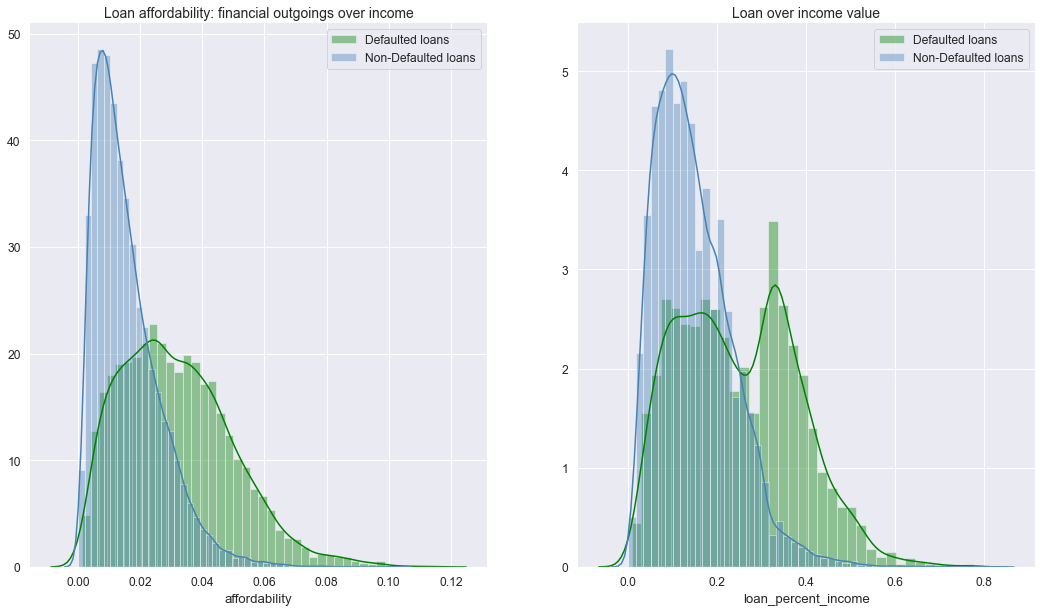

In [87]:
# Plot the univariate distribution
f, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.despine(left=True)

# Add configuraitons
axes[0].title.set_text("Loan affordability: financial outgoings over income")
axes[0].title.set_size(14)

axes[1].title.set_text("Loan over income value")
axes[1].title.set_size(14)

##########################
# Affordability
##########################
# Defaulted clients
fig_amount = sns.distplot(df_loans_cp_analysis[df_loans_cp_analysis.loan_status==1].affordability,kde=True,color="green",label="Defaulted loans",ax=axes[0])
# Non-defaulted clients
fig_amount = sns.distplot(df_loans_cp_analysis[df_loans_cp_analysis.loan_status==0].affordability,kde=True,color="steelblue",label="Non-Defaulted loans",ax=axes[0])
# Show the legend
axes[0].legend(loc='upper right')

##########################
# Loan percent income
##########################
# Defaulted clients
fig_amount = sns.distplot(df_loans_cp_analysis[df_loans_cp_analysis.loan_status==1].loan_percent_income,kde=True,color="green",label="Defaulted loans",ax=axes[1])
# Non-defaulted clients
fig_amount = sns.distplot(df_loans_cp_analysis[df_loans_cp_analysis.loan_status==0].loan_percent_income,kde=True,color="steelblue",label="Non-Defaulted loans",ax=axes[1])
# Show the legend
axes[1].legend(loc='upper right')

Differences between the two distributions are clearly visible from the image above: with no surprising, non-defaulted loans show much higher financial stability with respect to their counterparts. This might be a tremendously significant variable for modelling given the distinctions between the two groups are so evident.

# (3) A combined analysis: between bivariate and multivariate analysis

This section focuses on multivariate analysis with the objective of comparing multiple variables and see whether we can find any additional information or even hidden patterns in the data that might be useful for modelling purposes. Visualizations here will be a key tool for our purposes and for this reason, they will guide us along the way.

In [88]:
# Merge the two datasets
df_analysis = df_loans_cp_analysis.drop(columns=["id_cp","fk_cp"])
# Make sure there are no more missing values
df_analysis.dropna(inplace=True)

In [89]:
# Get a few information on the new dataset
print(f"The dataset for the combined analysis is characterized by {df_analysis.shape[0]} observations and {df_analysis.shape[1]} features")
df_analysis.head()

The dataset for the combined analysis is characterized by 28632 observations and 13 features


,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income,cp_income,cp_home_ownership,cp_person_default_on_file,cp_emp_title,cp_cred_period,cp_age_bucket,affordability
1,EDUCATION,B,1000,11.14,0,0.104,9600,OWN,N,MIDDLE,SHORT,YOUNGER,0.011604
2,MEDICAL,C,5500,12.87,1,0.573,9600,MORTGAGE,N,JUNIOR,SHORT,YOUNGER,0.073734
3,MEDICAL,C,35000,15.23,1,0.534,65500,RENT,N,MIDDLE,SHORT,YOUNGER,0.081382
4,MEDICAL,C,35000,14.27,1,0.643,54400,RENT,Y,SENIOR,MEDIUM,YOUNGER,0.091811
5,VENTURE,A,2500,7.14,1,0.253,9900,OWN,N,JUNIOR,SHORT,YOUNGER,0.018030


In [483]:
# Define function for plotting
def sns_multivariate(*plot_args):

    # Retrieve graph options
    plot_dict = plot_args[0]
    plot_options = plot_dict["plot_options"]

    # Settings
    df_plot = plot_dict["df"]
    x = plot_dict["x"]
    y = plot_dict["y"]
    fig_size = plot_options["fig_size"]
    plt.figure(figsize=fig_size)

    # Differentiate between graphs

    if plot_options["kind"] == "bar":
        g = sns.barplot(x=x, y=y, data=df_plot,palette=plot_options["palette"])
    elif plot_options["kind"] == "count":
        g = sns.countplot(x=x,hue=plot_dict["hue"],data=df_plot,palette=plot_options["palette"],order=plot_options["order"])
        g.legend(loc="upper left")
    elif plot_options["kind"] == "lineplot":
        g = sns.lineplot(x=x,y=y,data=df_plot,palette=plot_options["palette"])
    elif plot_options["kind"] == "boxplot":
        g = sns.boxplot(data=df_plot,x=x,y=y)
    elif plot_options["kind"] == "violin":
        if plot_options["order"]:
            g = sns.violinplot(data=df_plot, x=x, y=y, hue=plot_dict["hue"],palette=plot_options["palette"],inner="quart",split=True,order=plot_options["order"])
        else:
            g = sns.violinplot(data=df_plot, x=x, y=y, hue=plot_dict["hue"],palette=plot_options["palette"],inner="quart",split=True)
    elif plot_options["kind"] == "scatter":
        g = sns.scatterplot(x=x,y=y,data=df_plot,s=40)
    elif plot_options["kind"] == "lmplot":
        g = sns.lmplot(x=x,y=y,data=df_plot,hue=plot_dict["hue"],y_jitter=0.3,order=plot_dict["order"],size=plot_dict["size"],aspect=plot_dict["aspect"])
    elif plot_options["kind"] == "pairplot":
        if plot_dict["hue"] == "":
            g = sns.pairplot(data=df_plot,size=2.5)
            g.fig.suptitle(f"Pair-plots between {len(df_plot.columns)} variables", y=1.1) # y= some height > 1
        else: # hue on!
            g = sns.pairplot(data=df_plot,size=2.5,hue=plot_dict["hue"],palette=plot_options["palette"])
            g.fig.suptitle(f"Pair-plots between {len(df_plot.columns)-1} variables - Grouped by '{plot_dict['hue']}'", y=1.1) # y= some height > 1      
    else:
        raise Exception("Not a valid graph option")

    # Graphs to exclude from options
    if plot_options["kind"] not in ["pairplot","lmplot","lineplot"]:
        # Options shared by each graph (excluding exceptions)
        for p in g.patches:
            g.annotate(round(p.get_height(),2), (p.get_x() + p.get_width()/2, p.get_height()), ha='center', va='center', xytext=(0,10), textcoords = 'offset points')
    g.set_title(plot_options["title"],fontsize=20,fontweight="bold")
    g.set_xlabel(plot_options["x_label"],fontsize=16)
    g.set_ylabel(plot_options["y_label"],fontsize=16)

print("Multivariate plot function is ready for use")

Multivariate plot function is ready for use


1.23

## (3.1) Correlation Analysis

<AxesSubplot:title={'center':'Credit Risk - Correlation Matrix'}>

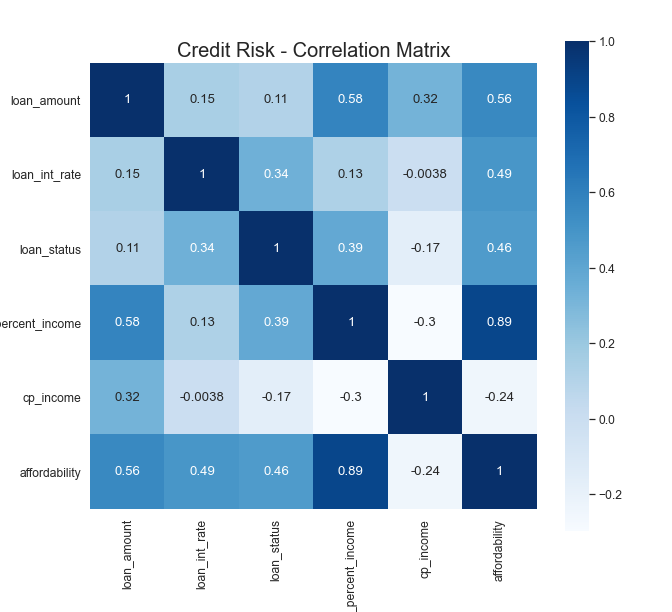

In [91]:
# General correlation matrix
corr_matr = df_analysis.corr()

# Plots
f,ax = plt.subplots(figsize=(10,9))
ax.set_title("Credit Risk - Correlation Matrix",fontsize=20)

# Heatmap
sns.heatmap(corr_matr, square=True, cmap="Blues",annot=True)

The **correlation coefficient** gives insights on the **linear relationship** between two variables. This coefficient ranges between \[-1,1] based on the intensity of such relationship: if positive (i.e. between \(0,1]) then the two variables are said to be "positively correlated" or, in other words, when one variable increases the other follows and viceversa. If instead this coefficient is negative (i.e. between \[-1,0)), then we are in a situation of "inversely related" variables: the increment of one of the two variables causes the other to drop.

The correlation matrix allows to extend this analysis for each of the possible combinations of numerical features in our dataset. The figure above provides already some key insights that are summarized in the following points:

* The age of the counterparty drives the relative credit history length. This is quite intuitive, as you would expect that the older a persong gets, the more likely it is that this person has been in a credit contract for a longer period of time.

* The ratio "loan over income" is correlated with "loan amount", "counterparty income" and "affordability". Despite the presence of correlation, these number is surprisingly not as high as expected, with the only exception of affordability which, due to its nature and the similarities between these two variables, along with the support of an economic intuition it will be kept as opposed to "loan over income", which will be drop.

* The loan amount is indeed correlated with the income of the counterparty to which the loan has been given. The intuition behind might be that the higher the income, the more likely it is for this person to sustain even higher repayments in the future (i.e. the principal and the interest rates of the loan)

* Lastly, although it is not usually appropriate to include a binary variable in the correlation analysis as it might results from too simplistic conclusions, some surprising results pop up here: the loan status is positively correlated with both interest rate and affordability. The underlying reasoning might be the following: since loan status takes value 1 when the counterparty defaults on that loan, the higher the financial outgoings with respect to the counterparty's income, the more likely it gets that a counterparty default on this loan.

Linear relationships are a great starting point to explore relationships among variables. Proceeding, we might want to see whether there are also some other trends that we can capture using other tools. 

## (3.2) What does a counterparty defaulting history can tell?

### (3.2.1) Relationship between loan grade and the historical defaulting flag for a counterparty

In [92]:
pd.crosstab(df_analysis["cp_person_default_on_file"],df_analysis["loan_grade"])

loan_grade,A,B,C,D,E,F,G
cp_person_default_on_file,,,,,,,
N,9401,9149,2823,1563,455,114,25
Y,0,0,2874,1684,415,95,34


The result here is not surprising and highlights also a trend: you would expect any lender to issue more high-graded loans to people that did not already defaulted in the past (i.e. with a better credit history) and less low-graded and riskier loans to people with a worse credit history. How does this flag relates to our dependent variable?

### (3.2.2) Counterparty defaulting history vs. loan status

In [93]:
defaults_cross_tab = pd.crosstab(df_analysis["cp_person_default_on_file"],df_analysis["loan_status"])
defaults_cross_tab

loan_status,0,1
cp_person_default_on_file,,
N,19254,4276
Y,3176,1926


In [94]:
# # mapping defaulted on file into 0-1 variables
# mapping_defaulted = {
#     "Y":1,
#     "N":0
# }
# # modify the dataframe to respect this convention
# df_analysis.loc[:,'cp_person_default_on_file'] = df_analysis.cp_person_default_on_file.map(mapping_defaulted)

# # assert 
# assert not np.any((df_analysis.cp_person_default_on_file == "N") & (df_analysis.cp_person_default_on_file == "Y"))

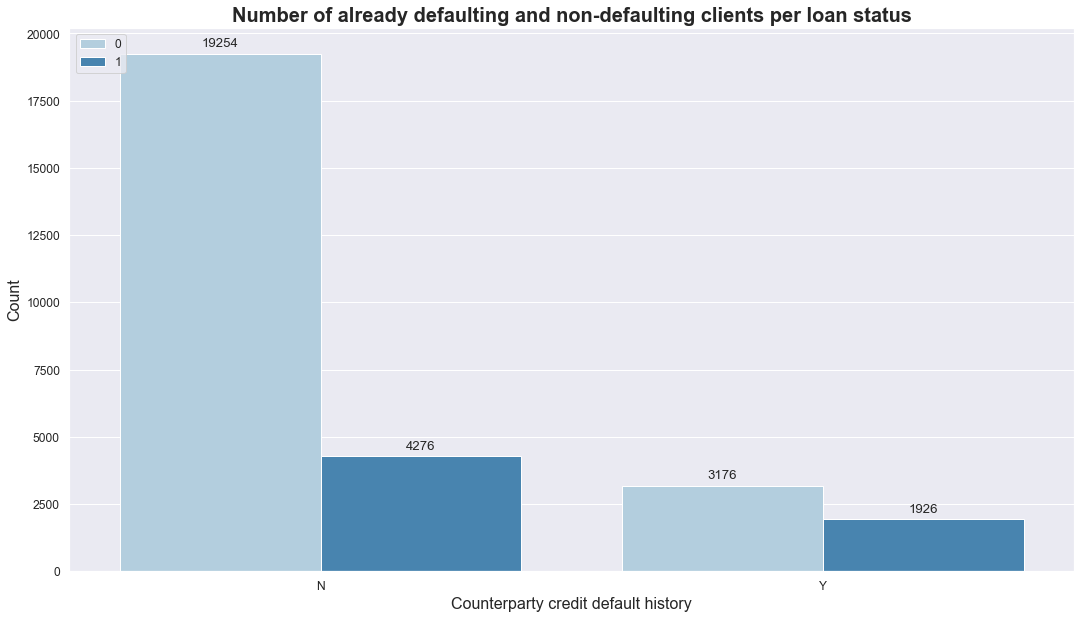

In [95]:
# Plot
plot_args = {
    "df": df_analysis,
    "x": "cp_person_default_on_file",
    "y": "", 
    "hue": "loan_status",
    "plot_options": {
        "kind": "count",
        "order": ["N","Y"],      
        "title": "Number of already defaulting and non-defaulting clients per loan status",
        "x_label": "Counterparty credit default history",
        "y_label": "Count",
        "palette": "Blues",
        "fig_size": (18,10)
    }
}

# Get the distribution
sns_multivariate(plot_args)

A significant proportion of non-defaulting loans is held by counterparties with good credit history, but on the other hand most of the defaulting loans belong to counterparties that did not default in the past. This might be due to several factors: either the bank might have softened controls and grant too much trust for this category, or might be due also to counterparties underlying characteristics or even asymmetric information between the two parties. What should be considered here is that, although representing counterintuitive results, this variable should turn to be relevant for modelling. 

In conclusion, it seems that a great amount of obligators defaulted for the first time, but there is also a proportion of counterparties that defaulted for the second time. Let's explore these findings more closely

In [96]:
# Retrieve info from the cross tab
total_0 = defaults_cross_tab.iloc[0].sum() # retrieve sum of the first row
defaulted_0 = defaults_cross_tab.iloc[0,1] # retrieve first row - second column

total_1 = defaults_cross_tab.iloc[1].sum() # retrieve sum of the second row
defaulted_1 = defaults_cross_tab.iloc[1,1] # retrieve second row - second column

# Calculate the ratios we are interested in
first_default = round((defaulted_0 / total_0) * 100,2)
second_default = round((defaulted_1 / total_1) * 100,2)

# Get the results
print(f"{first_default}% of counterparties have defaulted for the first time")
print(f"{second_default}% of counterparties have defaulted once again")

18.17% of counterparties have defaulted for the first time
37.75% of counterparties have defaulted once again


### (3.2.3) Is there a difference on the premium charged between flagged and non-flagged obligators

In [97]:
# Retrieve the cross tab
hist_int_rate_cross_tab = pd.crosstab(df_analysis["cp_person_default_on_file"],df_analysis["loan_intent"],values=df_analysis["loan_int_rate"],aggfunc="mean")
# Print the result
hist_int_rate_cross_tab

loan_intent,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE
cp_person_default_on_file,,,,,,
N,10.258902,10.266660,10.414747,10.338280,10.269477,10.221681
Y,14.546064,14.377482,14.571490,14.515942,14.541098,14.539738


In [98]:
# Get the average difference between the two categories
mean_diff_his_int_rate = round(hist_int_rate_cross_tab.iloc[1].mean() - hist_int_rate_cross_tab.iloc[0].mean(),2)
# 
print(f"The average premium difference between counterparties with good and bad credit history is: {(mean_diff_his_int_rate*100)} BP")

The average premium difference between counterparties with good and bad credit history is: 422.0 BP


In [99]:
# # Plot
# plot_args = {
#     "df": df_analysis,
#     "x": "loan_intent",
#     "y": "loan_int_rate", 
#     "hue": "loan_status",
#     "plot_options": {
#         "kind": "violin",
#         "title": "Distributions of interest rates per loan status across loan intents",
#         "x_label": "Loan intents",
#         "y_label": "Loan interest rate",
#         "palette": "Blues_r",
#         "fig_size": (18,10)
#     }
# }

# # Get the distribution
# sns_multivariate(plot_args)

The image above seems to suggest that, despite the range of loan intents, there seems to be a common trend among the categories: the interest rate distribution for defaulting clients is shared between categories but differs quite significantly with respect to that for non-defaulting clients. The interest rate distribution for non-defaulting counterparties is more concentrated towards much lower numbers.

Although the premium charged does not seem to vary between loan intents, there is an average deviation of more than 4% between those counterparties that have already defaulted and those that did not. This signals a major deviation in distribution of interest rates between the two categories

In [100]:
# # Plot
# plot_args = {
#     "df": df_analysis,
#     "x": "cp_person_default_on_file",
#     "y": "loan_int_rate", 
#     "hue": "loan_status",
#     "plot_options": {
#         "kind": "violin",
#         "title": "Distributions of interest rates per loan status based on the counterparties' credit history",
#         "x_label": "Counterparty defaulted in the past already?",
#         "y_label": "Loan interest rate",
#         "palette": "Blues_r",
#         "fig_size": (18,10)
#     }
# }

# # Get the distribution
# sns_multivariate(plot_args)

This image seems to give more details on the statement presented above: counterparties that already defaulted on some obligation have much higher interests to sustain, independently of the loan status.

## (3.3) Average interest rate for each rating?

We wish to explore the relationship between interest rates and the ratings assigned to loans. Indeed, there should be an obvious trend here: the lower the grade, the higher the interest rate to compensate for the risk.

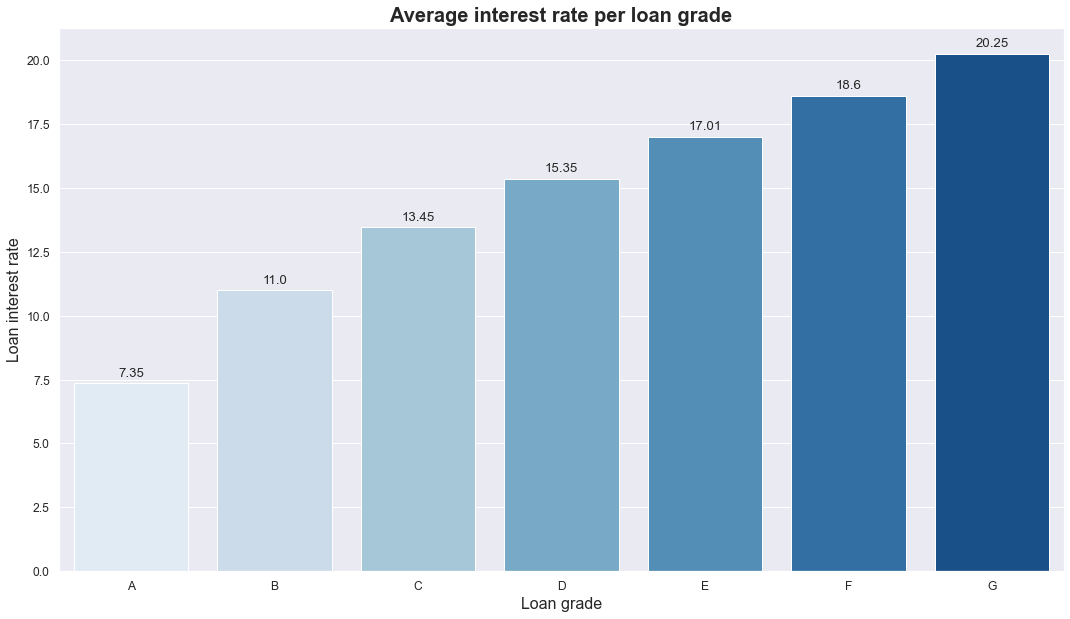

In [394]:
# Calculate the value
df_int_rate_grade = df_analysis.groupby(["loan_grade"]).mean().reset_index()

# Define histogram
# Define graph options
plot_args = {
    "df": df_int_rate_grade,
    "x": "loan_grade",
    "y": "loan_int_rate", 
    "hue" : "",
    "plot_options": {
        "kind": "bar",
        "title": "Average interest rate per loan grade",
        "x_label": "Loan grade",
        "y_label": "Loan interest rate",
        "palette": "Blues",
        "fig_size": (18,10),
    }
}


# Plot
sns_multivariate(plot_args)

The trend is reflected also in the data: the average premium charged to counterparties increases the riskier the loans becomes. The following graph shows the same trend and enters into more details to explore whether the distribution of the interest rate for each grade varies between defaulting and non-defaulting loans, which does not seem to be the case.

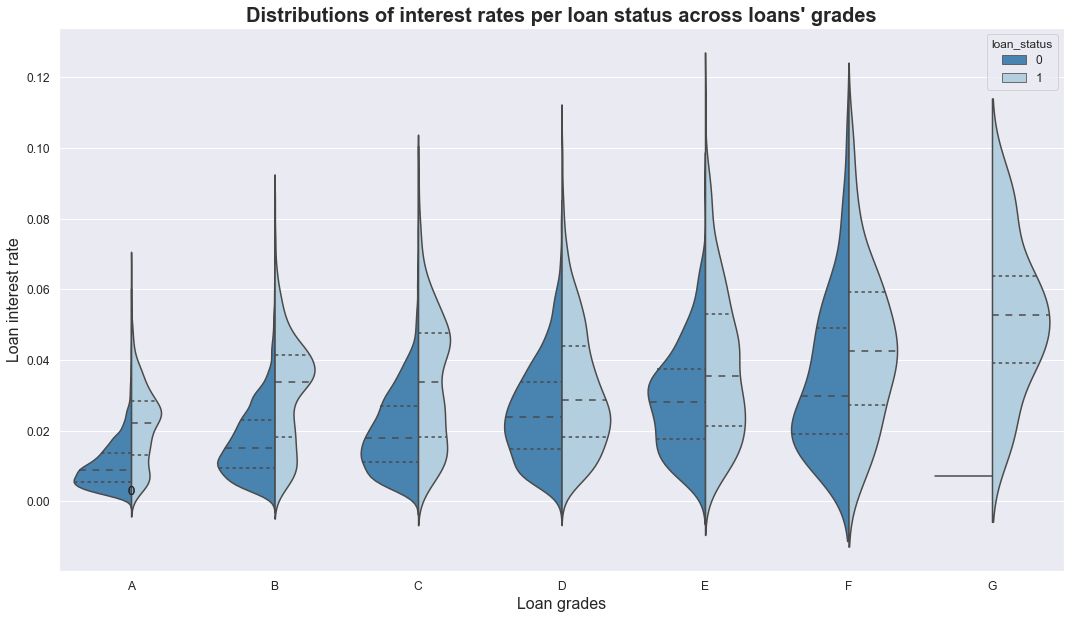

In [102]:
# Loan-status vs. interest rate
plot_args = {
    "df": df_analysis,
    "x": "loan_grade",
    "y": "affordability", 
    "hue": "loan_status",
    "plot_options": {
        "kind": "violin",
        "order": sorted(df_analysis.loan_grade.unique()),
        "title": "Distributions of interest rates per loan status across loans' grades",
        "x_label": "Loan grades",
        "y_label": "Loan interest rate",
        "palette": "Blues_r",
        "fig_size": (18,10)
    }
}

# Get the distribution
sns_multivariate(plot_args)

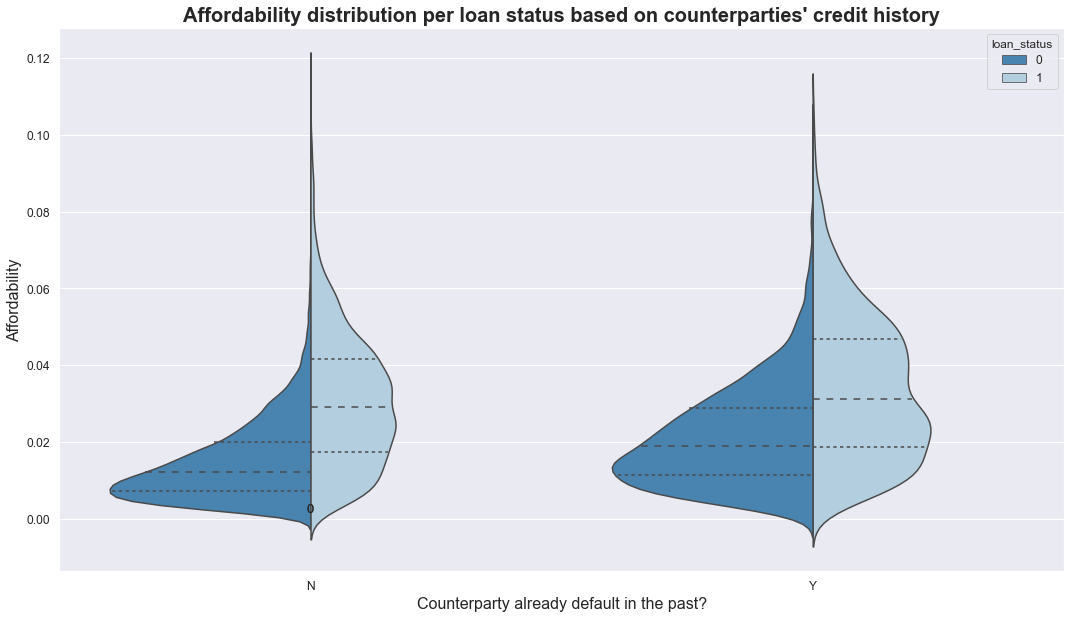

In [103]:
# Loan-status vs. interest rate
plot_args = {
    "df": df_analysis,
    "x": "cp_person_default_on_file",
    "y": "affordability", 
    "hue": "loan_status",
    "plot_options": {
        "kind": "violin",
        "order": sorted(df_analysis.cp_person_default_on_file.unique()),
        "title": "Affordability distribution per loan status based on counterparties' credit history",
        "x_label": "Counterparty already default in the past?",
        "y_label": "Affordability",
        "palette": "Blues_r",
        "fig_size": (18,10)
    }
}

# Get the distribution
sns_multivariate(plot_args)

## (3.4) How about people with mortgages? How this information affects the premium charged?

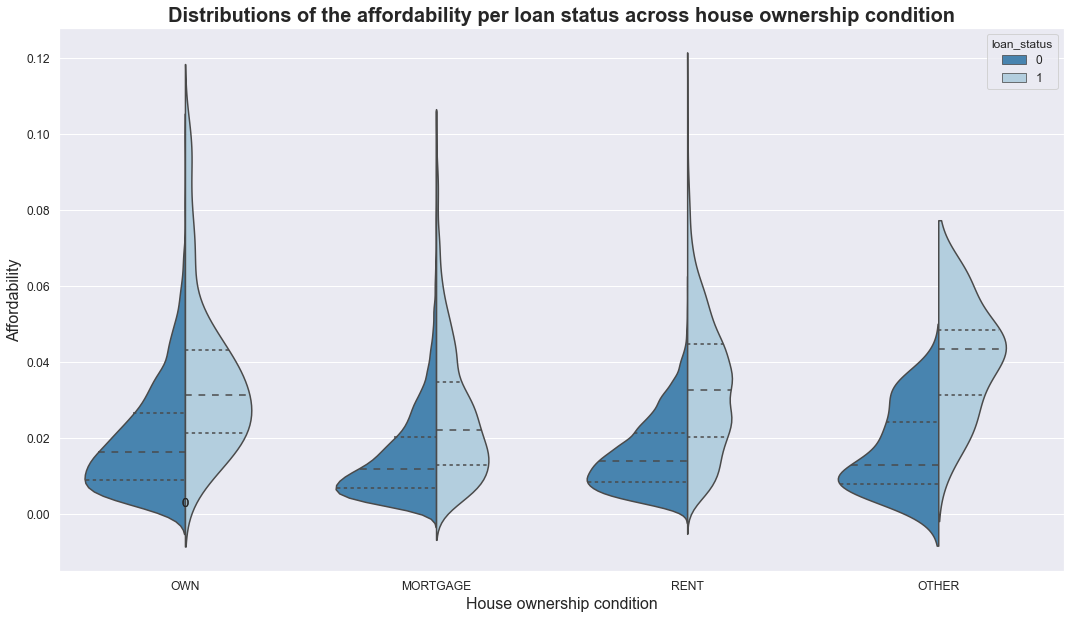

In [104]:
# Loan-status vs. interest rate
plot_args = {
    "df": df_analysis,
    "x": "cp_home_ownership",
    "y": "affordability", 
    "hue": "loan_status",
    "plot_options": {
        "kind": "violin",
        "order": "",
        "title": "Distributions of the affordability per loan status across house ownership condition",
        "x_label": "House ownership condition",
        "y_label": "Affordability",
        "palette": "Blues_r",
        "fig_size": (18,10)
    }
}

# Get the distribution
sns_multivariate(plot_args)

The distribution of the interest rates for defaulting clients that own a house seems to be more concentrated on low numbers compared to that of defaulting clients that have a mortgage, a renting contract or required a loan for all other reasons. Having a house should inform the lender that the client is less likely to default, as the house might play a similar role as that of a "collateral" in this type of transaction.

## (3.5) How about the distribution of the interest rate x intent per counterparties with debt? 

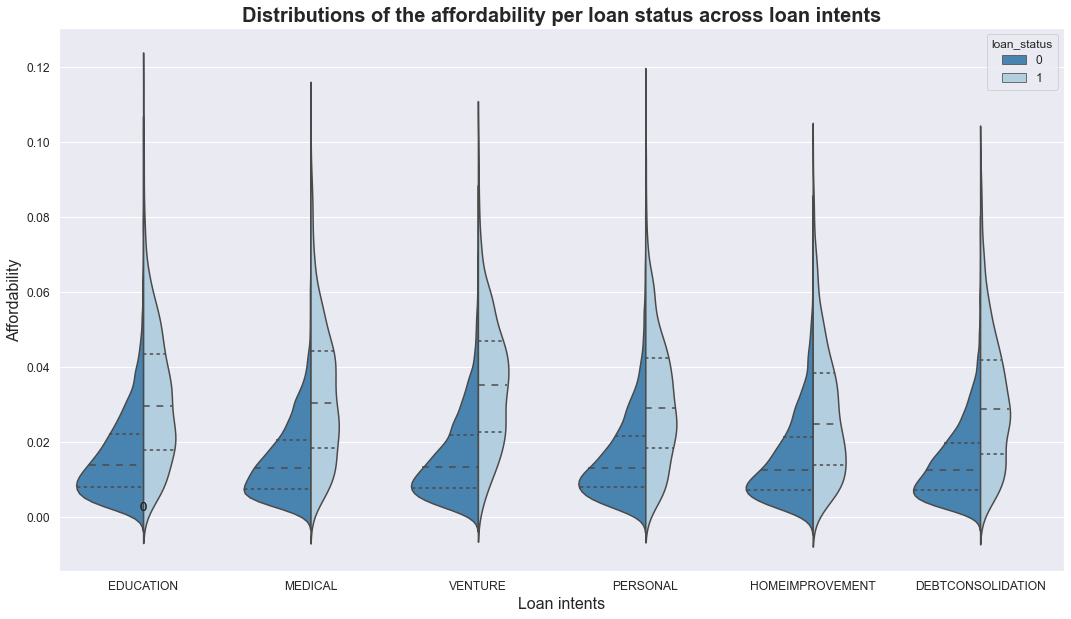

In [105]:
# Filter for people with mortgages
df_analysis_mortgages = df_analysis[(df_analysis.cp_home_ownership == "MORTGAGE") | (df_analysis.cp_home_ownership == "RENT")]

# Loan-status vs. interest rate
plot_args = {
    "df": df_analysis,
    "x": "loan_intent",
    "y": "affordability", 
    "hue": "loan_status",
    "plot_options": {
        "kind": "violin",
        "order": "",
        "title": "Distributions of the affordability per loan status across loan intents",
        "x_label": "Loan intents",
        "y_label": "Affordability",
        "palette": "Blues_r",
        "fig_size": (18,10)
    }
}

# Get the distribution
sns_multivariate(plot_args)

For non-defaulting clients the situation does not seem to vary that much, but for defaulting clients: medical, debt consolidation and venture seem to be the considered as the riskier intents by the financial istitution and therefore, charged with higher premium.

## (3.6) And what happens if we consider a counterparty's credit history?

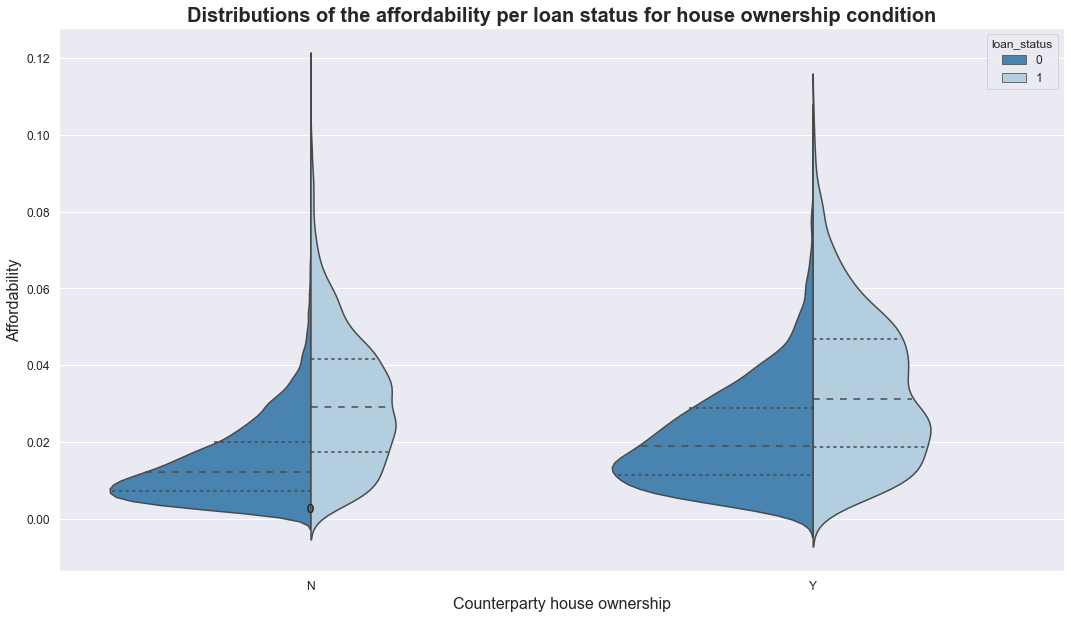

In [106]:
# Filter for people with mortgages
# df_analysis_unemployed = df_analysis[df_analysis.cp_emp_title == "UNEMPLOYED"]

# Loan-status vs. interest rate
plot_args = {
    "df": df_analysis,
    "x": "cp_person_default_on_file",
    "y": "affordability", 
    "hue": "loan_status",
    "plot_options": {
        "kind": "violin",
        "order": ["N","Y"],
        "title": "Distributions of the affordability per loan status for house ownership condition",
        "x_label": "Counterparty house ownership",
        "y_label": "Affordability",
        "palette": "Blues_r",
        "fig_size": (18,10)
    }
}

# Get the distribution
sns_multivariate(plot_args)

In [107]:
df_analysis.head()

,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income,cp_income,cp_home_ownership,cp_person_default_on_file,cp_emp_title,cp_cred_period,cp_age_bucket,affordability
1,EDUCATION,B,1000,11.14,0,0.104,9600,OWN,N,MIDDLE,SHORT,YOUNGER,0.011604
2,MEDICAL,C,5500,12.87,1,0.573,9600,MORTGAGE,N,JUNIOR,SHORT,YOUNGER,0.073734
3,MEDICAL,C,35000,15.23,1,0.534,65500,RENT,N,MIDDLE,SHORT,YOUNGER,0.081382
4,MEDICAL,C,35000,14.27,1,0.643,54400,RENT,Y,SENIOR,MEDIUM,YOUNGER,0.091811
5,VENTURE,A,2500,7.14,1,0.253,9900,OWN,N,JUNIOR,SHORT,YOUNGER,0.018030


This graph is particularly interesting as unemployment does not seem to affect the distribution of interest rates for counterparty's ownership that much. Surprisingly, owning a house if you are unemployed brings higher variability in terms of premium charged and, on average, you would get the same treatment (i.e. interest rate charged) as people in any other situation (either rent, mortgage or any other reason).

### (3.7) Are there any other trends between age buckets for affordability?

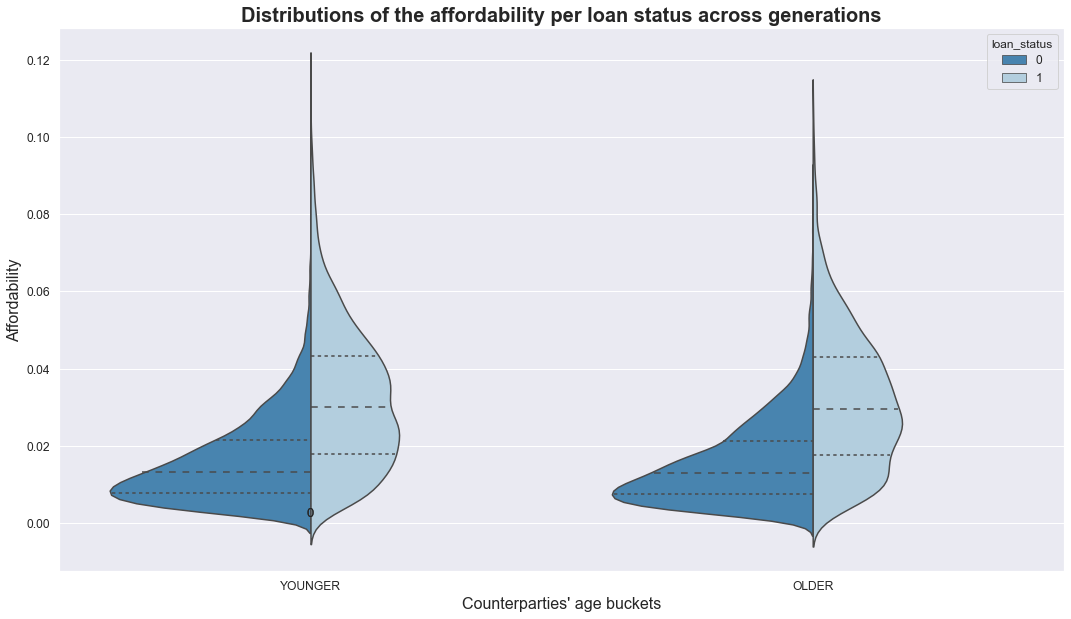

In [108]:
# Filter for people with mortgages
# df_analysis_unemployed = df_analysis[df_analysis.cp_emp_title == "UNEMPLOYED"]

# Loan-status vs. interest rate
plot_args = {
    "df": df_analysis,
    "x": "cp_age_bucket",
    "y": "affordability", 
    "hue": "loan_status",
    "plot_options": {
        "kind": "violin",
        "order": ["YOUNGER","OLDER"],
        "title": "Distributions of the affordability per loan status across generations",
        "x_label": "Counterparties' age buckets",
        "y_label": "Affordability",
        "palette": "Blues_r",
        "fig_size": (18,10)
    }
}

# Get the distribution
sns_multivariate(plot_args)

# (4) Data preparation

Most important part of the analysis!

### Drop Loan Grade
Loan grade is a variable that represents the PD calibration process (either internal or external) to understand which premium to apply to the loan when granted to a specific counterparty (in other words we cannot use a dependent variable [estimate] as a predictor in the model otherwise injecting further assumption which would simply be wrong!)

In [125]:
# Store loan_grade
df_loan_grade = df_analysis[["loan_grade"]]

In [126]:
# Drop loang 
df_data_preparation = df_analysis.drop(["loan_grade"],axis=1)

### Drop Loan Percent Income
This variable is mostly explained by affordability (a normalized version of loan percent income). Keeping it would surely inject multicollinearity in the model. Hence, it is drop right away

In [127]:
df_data_preparation = df_data_preparation.drop(["loan_percent_income"],axis=1)

### How the dataset looks like at this point?

In [128]:
# Get a sense of the data
df_data_preparation.head()

,loan_intent,loan_amount,loan_int_rate,loan_status,cp_income,cp_home_ownership,cp_person_default_on_file,cp_emp_title,cp_cred_period,cp_age_bucket,affordability
1,EDUCATION,1000,11.14,0,9600,OWN,N,MIDDLE,SHORT,YOUNGER,0.011604
2,MEDICAL,5500,12.87,1,9600,MORTGAGE,N,JUNIOR,SHORT,YOUNGER,0.073734
3,MEDICAL,35000,15.23,1,65500,RENT,N,MIDDLE,SHORT,YOUNGER,0.081382
4,MEDICAL,35000,14.27,1,54400,RENT,Y,SENIOR,MEDIUM,YOUNGER,0.091811
5,VENTURE,2500,7.14,1,9900,OWN,N,JUNIOR,SHORT,YOUNGER,0.018030


References

- Link 1: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- Link 2: https://datascience.stackexchange.com/questions/18516/necessity-of-balancing-positive-negative-examples-in-binary-classification-machi
- Link 3: (Point 3 -> reasons for high VIF coefficient for dummies: https://statisticalhorizons.com/multicollinearity)
- Link 4: multicollinearity -> http://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/4-5-Multiple-collinearity.html
- Link 5: Dummy trap -> https://stats.stackexchange.com/questions/415841/which-ml-algorithms-are-affected-by-dummy-variable-trap#:~:text=1%20Answer&text=The%20dummy%20variable%20trap%20is,information%20in%20the%20explanatory%20variables.&text=While%20you%20should%20of%20course,or%20some%20form%20of%20regularization.

Data preparation is a crucial and fundamental part of a machine learning workflow, The aim of this procedure is to get rid of as many data issues as possible (such as feature unbalancedness) and prepare the data such that it can be injected and consumed by the models.

### From categorical features to dummies

Machine learning models can only consume numerical features, and for this reason, we should find a way to convert categorical features into a numerical representation. This can be achieved through a dummy transformation, where each possible values of a categorical feature becomes a column that can take value 1 if that value is taken by an observation, or 0 if not. The first variable gets dropped due to multicollinearity issues. This could be handled using OneHotEncoder and regularization to reduce multicollinearity and automatically drop these variables.

In [130]:
# (1) Transform "object" variables into "categorical" features
for col in ['cp_home_ownership','cp_person_default_on_file','loan_intent','cp_emp_title','loan_status','cp_age_bucket']:
    df_data_preparation[col] = pd.Categorical(df_analysis[col])

# Get the result
df_data_preparation.dtypes

loan_intent                  category
loan_amount                     int64
loan_int_rate                 float64
loan_status                  category
cp_income                       int64
cp_home_ownership            category
cp_person_default_on_file    category
cp_emp_title                 category
cp_cred_period               category
cp_age_bucket                category
affordability                 float64
dtype: object

In [131]:
# (2) Separate numerical from categorical features
num_col = df_data_preparation.select_dtypes(exclude="category")
chr_col = df_data_preparation.select_dtypes(include="category").drop(["loan_status"],axis=1)
dep_var = df_data_preparation["loan_status"]

In [132]:
# (3) Retrieve dummy variables
# Get the dummies
encoded_chr_col = pd.get_dummies(chr_col,drop_first=True)

# Concat the columns to get the modelling database
df_data_preparation = pd.concat([dep_var,num_col,encoded_chr_col],axis=1)

# Get a sense of the data
df_data_preparation.head()

,loan_status,loan_amount,loan_int_rate,cp_income,affordability,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cp_home_ownership_OTHER,cp_home_ownership_OWN,cp_home_ownership_RENT,cp_person_default_on_file_Y,cp_emp_title_MIDDLE,cp_emp_title_SENIOR,cp_emp_title_UNEMPLOYED,cp_cred_period_MEDIUM,cp_cred_period_LONG,cp_age_bucket_OLDER
1,0,1000,11.14,9600,0.011604,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,1,5500,12.87,9600,0.073734,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,35000,15.23,65500,0.081382,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0
4,1,35000,14.27,54400,0.091811,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0
5,1,2500,7.14,9900,0.018030,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0


### From unbalancedness to balancedness using SMOTE (train_test_split)

The loan status represent the dependent variable (i.e. the variable we wish to model). This feature however is highly unbalanced, as the presence of non-defaulting loans is higher than the counterparts. The reason for balancing the set, as concisely explain in [2] (article), is purely due to the higher probability for the model to favour one class over the other if trained on the original data. 

There are multiple methods to solve the issue and we will make use of SMOTE, an algorithm that, accordingly to article [1], computes over-sampling by performing two tasks:

1) Create synthetic samples from the minor class (defaulted loans) instead of creating copies

2) Randomly choose one of the K-nearest-neighbors and use it to create a similar, but randomly tweaked, new observations.

In [141]:
# Import the library
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define the SMOTE object
os = SMOTE(random_state=100)

# Divide the columns
X = df_data_preparation.drop(["loan_status"],axis=1)
y = df_data_preparation[["loan_status"]]

# train-test split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Get the oversampled training data
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=X_train.columns)
os_data_y = pd.DataFrame(data=os_data_y,columns=['loan_status'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['loan_status']==0]))
print("Number of subscription",len(os_data_y[os_data_y['loan_status']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['loan_status']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['loan_status']==1])/len(os_data_X))

length of oversampled data is  31352
Number of no subscription in oversampled data 15676
Number of subscription 15676
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


The oversampling is performed only on the training data, as we wish to test the trained model on the test data, which is supposed to represent information that the model has never seen before.

### Retrieve the most important features
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html

[TODO] ADD A MUCH MORE DETAILED DESCRIPTION OF FEATURE SELECTION AND HOW IT WORKS IN SPECIFIC
The idea behind picking the most relevant features comes as a way to reduce the model complexity and get rid of features that have little-to-none contribution in predicting the dependent variable. These might also be problematic in terms of model assumption violations, one of which might be the presence of multicollinearity among the features. Note that the "feature selection" in this case will be entirely based on the average performance of the model over multiple runs. In other words, the procedure is extracting a-priori not-known features which lead the model to reach the maximum possible accuracy over the entire range of available variables. For this reason, as a sanity check, it is best practice to verify both the statistical and economic intuition behind the choice of specific independent variables to model the dependent variable.

In [142]:
# (1) Retrieve the appropriate libraries
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# (2) Backup features to be retrieved after features selection
ind_vars = df_data_preparation.drop(["loan_status"],axis=1).columns

Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.


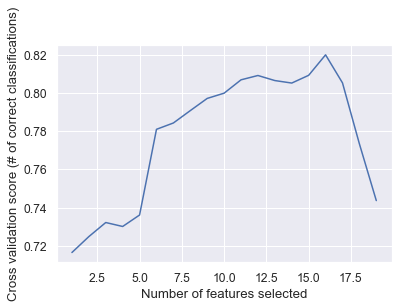

In [145]:
# (4) Fit the model on the oversampled training set

# Define the estimator to be cross-validated
logreg = LogisticRegression()

# Create RFE object and cross-validate it based on the accuracy (number of correct predictions)
rfe_cv = RFECV(estimator=logreg,step=1,cv=5,scoring="accuracy",verbose=3)
rfe_cv.fit(os_data_X, os_data_y.values.ravel())

# Retrieve the optimal number of features
print(f"The optimal number of features is: {rfe_cv.n_features_}")

# Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (# of correct classifications)")
# plt.plot(range(1, len(rfe_cv.grid_scores_) + 1), rfe_cv.grid_scores_)
# plt.show()

df_RFE = pd.DateFrame({'n_features': range(1, len(rfe_cv.grid_scores_) + 1), 'accuracy': rfe_cv.grid_scores_})

plot_args = {
    "df": df_analysis,
    "x": "cp_age_bucket",
    "y": "affordability", 
    "hue": "loan_status",
    "plot_options": {
        "kind": "violin",
        "order": ["YOUNGER","OLDER"],
        "title": "Distributions of the affordability per loan status across generations",
        "x_label": "Counterparties' age buckets",
        "y_label": "Affordability",
        "palette": "Blues_r",
        "fig_size": (18,10)
    }
}

sns_multivariate(plot_args)

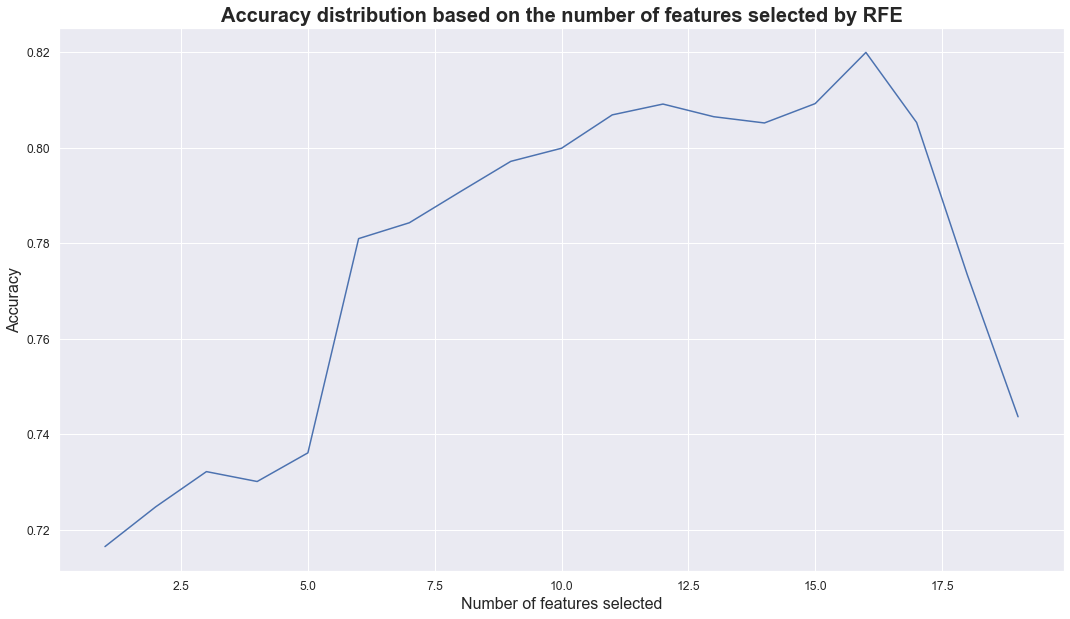

In [487]:
df_RFE = pd.DataFrame({'n_features': range(1, len(rfe_cv.grid_scores_) + 1), 'accuracy': rfe_cv.grid_scores_})
df_RFE
plot_args = {
    "df": df_RFE,
    "x": "n_features",
    "y": "accuracy",
    "plot_options": {
        "kind": "lineplot",
        "title": "Accuracy distribution based on the number of features selected by RFE",
        "x_label": "Number of features selected",
        "y_label": "Accuracy",
        "palette": "Blues_r",
        "fig_size": (18,10)
    }
}

sns_multivariate(plot_args)

In [188]:
# (5) Get the a-priori not-known best informative features
a_priori_ind_vars = ind_vars[rfe_cv.support_]

# (6) Proxy the features to be used for model estimation
X = os_data_X[a_priori_ind_vars]
y = os_data_y["loan_status"]

In [147]:
# Import the library
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [148]:
# Get a sense of the data we are using in this case
os_data_X.head()

,loan_amount,loan_int_rate,cp_income,affordability,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cp_home_ownership_OTHER,cp_home_ownership_OWN,cp_home_ownership_RENT,cp_person_default_on_file_Y,cp_emp_title_MIDDLE,cp_emp_title_SENIOR,cp_emp_title_UNEMPLOYED,cp_cred_period_MEDIUM,cp_cred_period_LONG,cp_age_bucket_OLDER
0,4000,14.54,36000,0.016156,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,8400,8.00,70000,0.009600,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2400,10.75,60000,0.004300,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1
3,10000,7.88,110000,0.007164,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,2400,9.62,42000,0.005497,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1


### Generalized VIF (with all the variables)

In [474]:
# Add a constant to the set to properly calculate VIF
general_X_VIF = os_data_X
# Calculate VIF
VIF = pd.DataFrame([round(variance_inflation_factor(general_X_VIF.values,i),2) for i in range(general_X_VIF.shape[1])],index=general_X_VIF.columns).reset_index()
# Store columns
VIF.columns = ["Feature","VIF"]
# Get the result
VIF

,Feature,VIF
0,loan_amount,8.75
1,loan_int_rate,10.28
2,cp_income,4.92
3,affordability,10.07
4,loan_intent_EDUCATION,1.42
5,loan_intent_HOMEIMPROVEMENT,1.28
6,loan_intent_MEDICAL,1.42
7,loan_intent_PERSONAL,1.38
8,loan_intent_VENTURE,1.41
9,cp_home_ownership_OTHER,1.01


Usually, a industry-best practice is that a VIF greater than 5 shows high correlation with the other variables. Based on this observation, most of the variables do not show any concern regarding multicollinearity with other features, with the exception of affordability and loan_percent_income, which, given the similarity between the two features, was expected. Also interest rate seems to be on the same line, which might also be linked to the loan_grade as there is a mapping between the two variables. What if we first get rid of loan_percent_income?

### RFE-based VIF

In [475]:
# (2) Recalculate VIF based on previous findings and iterative elimination of columns
RFE_X_VIF = X
# Calculate VIF
VIF_2 = pd.DataFrame([round(variance_inflation_factor(RFE_X_VIF.values,i),2) for i in range(RFE_X_VIF.shape[1])],index=RFE_X_VIF.columns).reset_index()
# Store columns
VIF_2.columns = ["Feature","VIF"]
# Get the result
VIF_2

,Feature,VIF
0,loan_int_rate,7.29
1,affordability,4.16
2,loan_intent_EDUCATION,1.40
3,loan_intent_HOMEIMPROVEMENT,1.27
4,loan_intent_MEDICAL,1.41
5,loan_intent_PERSONAL,1.37
6,loan_intent_VENTURE,1.40
7,cp_home_ownership_OTHER,1.01
8,cp_home_ownership_OWN,1.16
9,cp_home_ownership_RENT,2.33


It seems that we got rid of the multicollinearity right-away, which gives us confidence that we are in line with the assumption of logistic regression model. Let's try to see the VIF from the variables that are picked from recursive feature selection.

### RFE-based + correction + constant VIF

In [473]:
# (3) VIF on RFE variables
X_RFE = X.drop(["loan_int_rate"],axis=1).assign(const=1)
# Calculate VIF
VIF_RFE = pd.DataFrame([round(variance_inflation_factor(X_RFE.values,i),2) for i in range(X_RFE.shape[1])],index=X_RFE.columns).reset_index()
# Store columns
VIF_RFE.columns = ["Feature","VIF"]
# Get the result
VIF_RFE

,Feature,VIF
0,affordability,1.14
1,loan_intent_EDUCATION,1.26
2,loan_intent_HOMEIMPROVEMENT,1.20
3,loan_intent_MEDICAL,1.25
4,loan_intent_PERSONAL,1.25
5,loan_intent_VENTURE,1.28
6,cp_home_ownership_OTHER,1.00
7,cp_home_ownership_OWN,1.11
8,cp_home_ownership_RENT,1.15
9,cp_person_default_on_file_Y,1.02


interest rate is dropped and a constant is added to the list of variables before proceeding in building a logistic regression model. The main assumtions are covered: 

1) Lots of data
2) No multicollinearity between features
3) A lots of dummies as predictors should be good to produce a decent accuracy score!

# (5) Modelling

References:

- Link 1 (Logistic Regression Assumptions = https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

## (5.1) Model assumptions - statistical and economical reasoning

In [440]:
# Import the main libraries
import statsmodels.api as sm

# Logistic regression model using statsmodel library to retrieve the statistics (p-values and coefficients)
logit_model = sm.Logit(y,X_RFE,axis=1)

# Fit the model 
result=logit_model.fit()

# Get the results
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.375664
         Iterations 7
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.458     
Dependent Variable:      loan_status         AIC:                 23587.6288
Date:                    2020-09-13 18:05    BIC:                 23721.2773
No. Observations:        31352               Log-Likelihood:      -11778.   
Df Model:                15                  LL-Null:             -21732.   
Df Residuals:            31336               LLR p-value:         0.0000    
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          7.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
affor

# (5.2) Modelling: Logistic Regression

In [441]:
# Import most important libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

In [442]:
# (1) Store the dataset 
df_modelling = df_data_preparation.assign(const=1)

In [443]:
# (2) Get a sense of the data
df_modelling.head()

,loan_status,loan_amount,loan_int_rate,cp_income,affordability,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,...,cp_home_ownership_OWN,cp_home_ownership_RENT,cp_person_default_on_file_Y,cp_emp_title_MIDDLE,cp_emp_title_SENIOR,cp_emp_title_UNEMPLOYED,cp_cred_period_MEDIUM,cp_cred_period_LONG,cp_age_bucket_OLDER,const
1,0,1000,11.14,9600,0.011604,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
2,1,5500,12.87,9600,0.073734,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,35000,15.23,65500,0.081382,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
4,1,35000,14.27,54400,0.091811,0,0,1,0,0,...,0,1,1,0,1,0,1,0,0,1
5,1,2500,7.14,9900,0.018030,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [444]:
# (2) Retrieve X and y for modelling fit
X_modelling = df_modelling[X_RFE.drop(["const"],axis=1).columns]
y_modelling = df_modelling[["loan_status"]]

In [445]:
# Define the scorers
scorers = {
    "accuracy": "accuracy",
    "recall": "recall",
    "precision": "precision"
    # "f1": "f1",
    # "neg_log_loss": "neg_log_loss"
}

In [446]:
# Define the parameters to optimze
params = {
    "logisticregression__C": np.logspace(-3,3,7),       # regularization purposes 
    "logisticregression__penalty":["l2"]                # l1 -> lasso, l2 -> ridge
}

In [447]:
#########
# Logistic regression ML pipeline definition
#########
def get_log_pipeline():
    # Apply OneHotEncoding to retrieve dummy variables
    # OHE_transformer = OneHotEncoder() # NOT WORKING -> replaced by pd.get_dummioes
    # Apply SMOTE to balance the dataset
    # SMOTE_sampling = SMOTE()
    # Apply recursive feature selection on a logistic regression model
    # RFE_selection = RFE(LogisticRegression())
    # Define the model
    log_reg_model = LogisticRegression()
    # Return the pipeline
    return make_pipeline(log_reg_model)

# Print the pipeline
get_log_pipeline()

Pipeline(steps=[('logisticregression', LogisticRegression())])

In [448]:
#########
# Logistic regression fine-tuning and cross-validation definition
#########
def get_optimal_model(X,y):
    # Retrieve the pipeline
    log_reg_pipeline = get_log_pipeline()    
    # Retrieve the optimal model
    log_reg_opt = GridSearchCV(log_reg_pipeline,param_grid=params,scoring=scorers,refit='accuracy',cv=5,verbose=3)
    # Fit the optimal model
    log_reg_opt.fit(X,y)
    # Return the fitted optimal models
    return log_reg_opt

In [449]:
# Retrieve the optimal model
logistic_optimal = get_optimal_model(X_modelling,y_modelling)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] logisticregression__C=0.001, logisticregression__penalty=l2 .....
[CV]  logisticregression__C=0.001, logisticregression__penalty=l2, accuracy=0.783, precision=0.000, recall=0.000, total=   0.1s
[CV] logisticregression__C=0.001, logisticregression__penalty=l2 .....
[CV]  logisticregression__C=0.001, logisticregression__penalty=l2, accuracy=0.783, precision=0.000, recall=0.000, total=   0.1s[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s

[CV] logisticregression__C=0.001, logisticregression__penalty=l2 .....
[CV]  logisticregression__C=0.001, logisticregression__penalty=l2, accuracy=0.783, precision=0.000, recall=0.000, total=   0.1s
[CV] logisticregression__C=0.001, logisticregression__penalty=l2 .....
[CV]  logisticregression__C=0.0

In [450]:
# Retrieve best model params
print(f"Best model parameters: {logistic_optimal.best_params_}")
print(f"Best score (accuracy): {logistic_optimal.best_score_}")

Best model parameters: {'logisticregression__C': 100.0, 'logisticregression__penalty': 'l2'}
Best score (accuracy): 0.8384325804181051


# The optimal logistic model and some statistics

### Retrieve the optimal model

In [451]:
# Define the optimal model
my_logistic_optimal_model = \
    LogisticRegression(\
        C=logistic_optimal.best_params_["logisticregression__C"],\
        penalty=logistic_optimal.best_params_["logisticregression__penalty"]\
    )

### Fit and predict

In [452]:
## Fit the model and predict with a simple train_test split
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Fit the model
my_logistic_optimal_model.fit(X_train,y_train)

# Get the predictions
y_pred = my_logistic_optimal_model.predict(X_test)

### Confusion Matrix

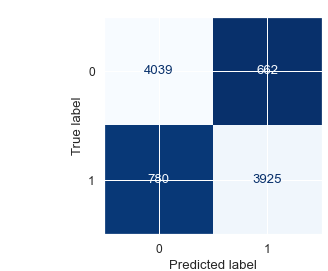

In [453]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

# Retrieve confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix

plt_conf_matr = \
    plot_confusion_matrix(\
        estimator=my_logistic_optimal_model,\
        X=X_test,\
        y_true=y_test,\
        labels=[0,1],\
        cmap='Blues_r',
    )
disp.ax_.set_title("Logistic Regression - Confusion Matrix")
plt.show()

### Classification Report

In [454]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.84      0.86      0.85      4701
           1       0.86      0.83      0.84      4705

    accuracy                           0.85      9406
   macro avg       0.85      0.85      0.85      9406
weighted avg       0.85      0.85      0.85      9406



### ROC Curve

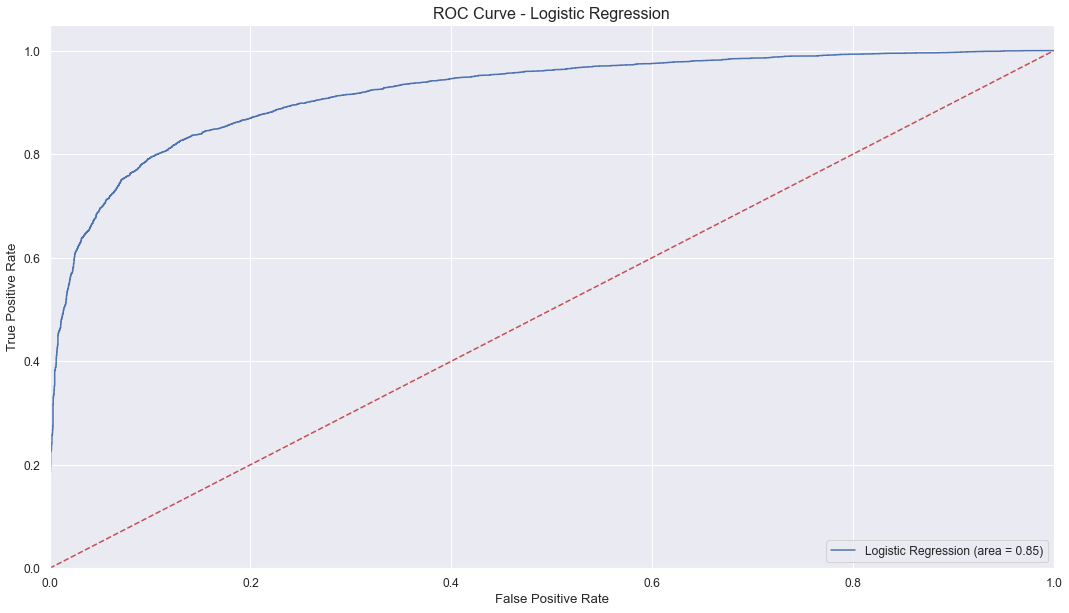

In [455]:
# Print the ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Get the logit ROC AUC score
logit_roc_auc = roc_auc_score(y_test, y_pred)

# Get the thresholds and the curve
fpr, tpr, thresholds = roc_curve(y_test, my_logistic_optimal_model.predict_proba(X_test)[:,1])

# Plot the figure
plt.figure(figsize=(18,10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression',fontsize=16)
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# (5.3) Modelling: Gradient Boosting Classifier

In [456]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import fbeta_score, make_scorer

In [457]:
# Parameter grid containing the possible parameters values to be optimized through GridSearchCV. 
param_grid_ensemble = {
    "gradientboostingclassifier__loss": ["deviance"],
    "gradientboostingclassifier__learning_rate": np.linspace(0.05,0.2,3), # percentage of contribution of each new base learner 
    "gradientboostingclassifier__n_estimators": [1000], # number of base learners iteratively trained
    "gradientboostingclassifier__n_iter_no_change": [5], # rounds of straight deterioration allowed before stopping
}

# Link: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

# dict_keys(['memory', 'steps', 'verbose', 'gradientboostingclassifier', 'gradientboostingclassifier__ccp_alpha', 'gradientboostingclassifier__criterion', 'gradientboostingclassifier__init', 'gradientboostingclassifier__learning_rate', '', 'gradientboostingclassifier__max_depth', 'gradientboostingclassifier__max_features', 'gradientboostingclassifier__max_leaf_nodes', 'gradientboostingclassifier__min_impurity_decrease', 'gradientboostingclassifier__min_impurity_split', 'gradientboostingclassifier__min_samples_leaf', 'gradientboostingclassifier__min_samples_split', 'gradientboostingclassifier__min_weight_fraction_leaf', 'gradientboostingclassifier__n_estimators', 'gradientboostingclassifier__n_iter_no_change', 'gradientboostingclassifier__presort', 'gradientboostingclassifier__random_state', 'gradientboostingclassifier__subsample', 'gradientboostingclassifier__tol', 'gradientboostingclassifier__validation_fraction', 'gradientboostingclassifier__verbose', 'gradientboostingclassifier__warm_start'])

### Retrieve optimal scorer values to define the beta for fbeta_scorer 

(Link: https://andersource.dev/2019/09/30/f-score-deep-dive.html)

In [458]:
# Extract the optimal values for all the scorers
results = logistic_optimal.cv_results_

# Optimal values of each score
log_reg_optimal_scores = dict()

# Store each optimal score
for scorer in sorted(scorers):
    sample = 'test'
    sample_score_mean = results[f'mean_test_{scorer}']
    best_index = np.nonzero(results[f'rank_test_{scorer}'] == 1)[0][0] # the one where in the ordered indexes is equal to 1
    best_score = results[f'mean_test_{scorer}'][best_index]
    # print(f"Best index for {scorer}: {best_index}")
    log_reg_optimal_scores[f"{scorer}"] = best_score
    print(f"Best score for {scorer}: {best_score}")

Best score for accuracy: 0.8384325804181051
Best score for precision: 0.765827529381973
Best score for recall: 0.4101874138961816


In [459]:
scorers_GB = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': make_scorer(fbeta_score, beta = np.sqrt(log_reg_optimal_scores['precision'] / log_reg_optimal_scores['recall'])**3 # beta = sqrt(R)^3 
    )
}

### Gradient Boosting Model

In [460]:
#########
# Gradient boosting classifier ML pipeline definition
#########
def get_ensemble_pipeline():
    # Apply OneHotEncoding to retrieve dummy variables
    # OHE_transformer = OneHotEncoder() # NOT WORKING -> replaced by pd.get_dummioes
    # Apply SMOTE to balance the dataset
    # SMOTE_sampling = SMOTE()
    # Apply recursive feature selection on a logistic regression model
    # RFE_selection = RFE(LogisticRegression())
    # Define the model
    gb_model = GradientBoostingClassifier()
    # Return the pipeline
    return make_pipeline(gb_model)

# Print the pipeline
get_ensemble_pipeline()

Pipeline(steps=[('gradientboostingclassifier', GradientBoostingClassifier())])

In [461]:
# Retrieve the optimal Gradient Boosting model 
def get_optimal_ensemble(x=X,y=y,param_grid=param_grid_ensemble):
    # Retrieve the relative pipeline
    my_pipeline = get_ensemble_pipeline()
    # Istantiate the grid search object to perform parameter optimization and cross validation procedures based on negative MSE metricng
    my_ensemble_model = GridSearchCV(my_pipeline,param_grid,cv=5,scoring=scorers_GB,refit="f1",verbose=3)
    # Fits the data and finds the best parameters according to GridSearchCV
    my_ensemble_model.fit(x,y)
    # Return the optimal ensemble model
    return my_ensemble_model

In [462]:
# Retrieve optimal gradient boosting
my_ensemble_optimal = get_optimal_ensemble(X_modelling,y_modelling)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] gradientboostingclassifier__learning_rate=0.05, gradientboostingclassifier__loss=deviance, gradientboostingclassifier__n_estimators=1000, gradientboostingclassifier__n_iter_no_change=5 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  gradientboostingclassifier__learning_rate=0.05, gradientboostingclassifier__loss=deviance, gradientboostingclassifier__n_estimators=1000, gradientboostingclassifier__n_iter_no_change=5, accuracy=0.865, f1=0.502, precision=0.827, recall=0.474, total=   4.1s
[CV] gradientboostingclassifier__learning_rate=0.05, gradientboostingclassifier__loss=deviance, gradientboostingclassifier__n_estimators=1000, gradientboostingclassifier__n_iter_no_change=5 
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[CV]  gradientboostingclassifier__learning_rate=0.05, gradientboostingclassifier__loss=deviance, gradientboostingclassifier__n_estimat

In [463]:
# Retrieve best model params
print(f"Best model parameters: {my_ensemble_optimal.best_params_}")
print(f"Best score (f1_score): {my_ensemble_optimal.best_score_}")

Best model parameters: {'gradientboostingclassifier__learning_rate': 0.125, 'gradientboostingclassifier__loss': 'deviance', 'gradientboostingclassifier__n_estimators': 1000, 'gradientboostingclassifier__n_iter_no_change': 5}
Best score (f1_score): 0.4286180444414545


# Retrieve the optimal gradient boosting classifier

In [464]:
# Define the optimal model
my_ensemble_optimal_model = \
    GradientBoostingClassifier(\
        learning_rate=my_ensemble_optimal.best_params_["gradientboostingclassifier__learning_rate"],\
        loss=my_ensemble_optimal.best_params_["gradientboostingclassifier__loss"],\
        n_estimators=my_ensemble_optimal.best_params_["gradientboostingclassifier__n_estimators"],\
        n_iter_no_change=my_ensemble_optimal.best_params_["gradientboostingclassifier__n_iter_no_change"]
    )

In [465]:
## Fit the model and predict with a simple train_test split
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Fit the model
my_ensemble_optimal_model.fit(X_train,y_train)

# Get the predictions
y_pred = my_ensemble_optimal_model.predict(X_test)

### Confusion Matrix

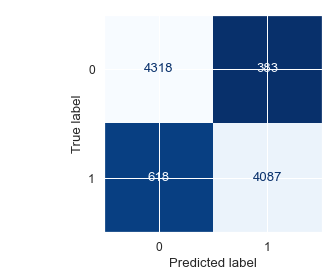

In [466]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

# Retrieve confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix

plt_conf_matr = \
    plot_confusion_matrix(\
        estimator=my_ensemble_optimal_model,\
        X=X_test,\
        y_true=y_test,\
        labels=[0,1],\
        cmap='Blues_r',
    )
disp.ax_.set_title("Gradient Boosting - Confusion Matrix")
plt.show()

In [467]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.87      0.92      0.90      4701
           1       0.91      0.87      0.89      4705

    accuracy                           0.89      9406
   macro avg       0.89      0.89      0.89      9406
weighted avg       0.89      0.89      0.89      9406



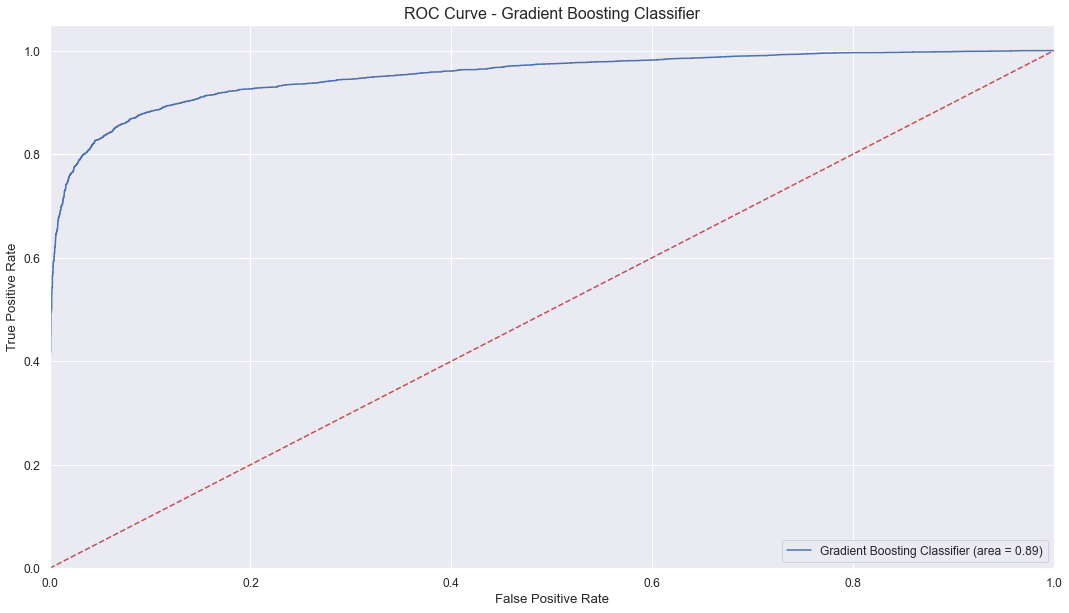

In [468]:
# Print the ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Get the logit ROC AUC score
gb_roc_auc = roc_auc_score(y_test, y_pred)

# Get the thresholds and the curve
fpr, tpr, thresholds = roc_curve(y_test, my_ensemble_optimal_model.predict_proba(X_test)[:,1])

# Plot the figure
plt.figure(figsize=(18,10))
plt.plot(fpr, tpr, label='Gradient Boosting Classifier (area = %0.2f)' % gb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting Classifier',fontsize=16)
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Retrieve the optimal scorers

In [469]:
# Extract the optimal values for all the scorers
results = my_ensemble_optimal.cv_results_

# Optimal values of each score
ensemble_optimal_scores = dict()

# Store each optimal score
for scorer in sorted(scorers_GB):
    sample = 'test'
    sample_score_mean = results[f'mean_test_{scorer}']
    best_index = np.nonzero(results[f'rank_test_{scorer}'] == 1)[0][0] # the one where in the ordered indexes is equal to 1
    best_score = results[f'mean_test_{scorer}'][best_index]
    # print(f"Best index for {scorer}: {best_index}")
    ensemble_optimal_scores[f"{scorer}"] = best_score
    print(f"Best score for {scorer}: {best_score}")

Best score for accuracy: 0.8458368638337157
Best score for f1: 0.4286180444414545
Best score for precision: 0.7848300687050189
Best score for recall: 0.40148319513399705


In [470]:
ensemble_optimal_scores

{'accuracy': 0.8458368638337157,
 'f1': 0.4286180444414545,
 'precision': 0.7848300687050189,
 'recall': 0.40148319513399705}

# Model accuracy improvements w.r.t baseline

In [471]:
# Calculate baseline model accuracy based on the credit history of the clients (bad obligators over total)
baseline_accuracy = 1 - round(defaults_cross_tab.iloc[:,1].sum() / df_modelling.shape[0],2)

In [472]:
# Retrieve the difference in terms of accuracy
print(f"The optimal model is {round(ensemble_optimal_scores['accuracy'] - baseline_accuracy,2)*100}% more accurate than the baseline model in predicting defaulting counterparties")

The optimal model is 7.000000000000001% more accurate than the baseline model in predicting defaulting counterparties


[CIT]
We have improved the accuracy of our model from 78% to 85% by leveraging *Principle Component Analysis and hyperparameter tuning.

The current process for credit assessment had a default rate of 22% as shown below. The new credit risk assessment algorithm which we had develop with principal component analysis and logistic regression had a reduced default rate from 22% to 14% (1-0.86).

The 5% increase in accuracy resulted in the an 8% reduction of defaulted loans, minimizing the lender's risk and improving their confidence to lend credit.

# Calibration Benchmarking

Let's use loan grade calibration to benchmark the best model predictions against the average default rate for each grade

In [368]:
# (1) Count number of non-defaulting and defaulting loans x loan grade
total_per_grade_per_status = df_analysis.groupby(["loan_grade","loan_status"]).size().reset_index(name='counts')
# Return the result
total_per_grade_per_status

,loan_grade,loan_status,counts
0,A,0,8497
1,A,1,904
2,B,0,7696
3,B,1,1453
4,C,0,4540
5,C,1,1157
6,D,0,1325
7,D,1,1922
8,E,0,308
9,E,1,562


In [370]:
# (2) Count total observations per grade
total_per_grade = df_analysis.groupby(["loan_grade"]).size().reset_index(name='total')
# Return the result
total_per_grade

,loan_grade,total
0,A,9401
1,B,9149
2,C,5697
3,D,3247
4,E,870
5,F,209
6,G,59


In [371]:
# (3) Join tables
defaulting_per_grade_per_status = pd.merge(total_per_grade_per_status,total_per_grade,how="inner",on="loan_grade")
# Return the results
defaulting_per_grade_per_status

,loan_grade,loan_status,counts,total
0,A,0,8497,9401
1,A,1,904,9401
2,B,0,7696,9149
3,B,1,1453,9149
4,C,0,4540,5697
5,C,1,1157,5697
6,D,0,1325,3247
7,D,1,1922,3247
8,E,0,308,870
9,E,1,562,870


In [373]:
# (4) Calculate defaulting and non-defaulting rates
defaulting_per_grade_per_status["prop"] = round(defaulting_per_grade_per_status["counts"] / defaulting_per_grade_per_status["total"],3)
# Return the result
defaulting_per_grade_per_status

,loan_grade,loan_status,counts,total,prob,prop
0,A,0,8497,9401,0.904,0.904
1,A,1,904,9401,0.096,0.096
2,B,0,7696,9149,0.841,0.841
3,B,1,1453,9149,0.159,0.159
4,C,0,4540,5697,0.797,0.797
5,C,1,1157,5697,0.203,0.203
6,D,0,1325,3247,0.408,0.408
7,D,1,1922,3247,0.592,0.592
8,E,0,308,870,0.354,0.354
9,E,1,562,870,0.646,0.646


In [374]:
# (5) Retrieve PDs per grade
pd_calibration = defaulting_per_grade_per_status[defaulting_per_grade_per_status.loan_status == 1]
# Rename column to match PD
pd_calibration.rename(columns={'prop':'default_rate'},inplace=True)
# Return result
pd_calibration

,loan_grade,loan_status,counts,total,prob,default_rate
1,A,1,904,9401,0.096,0.096
3,B,1,1453,9149,0.159,0.159
5,C,1,1157,5697,0.203,0.203
7,D,1,1922,3247,0.592,0.592
9,E,1,562,870,0.646,0.646
11,F,1,146,209,0.699,0.699
13,G,1,58,59,0.983,0.983


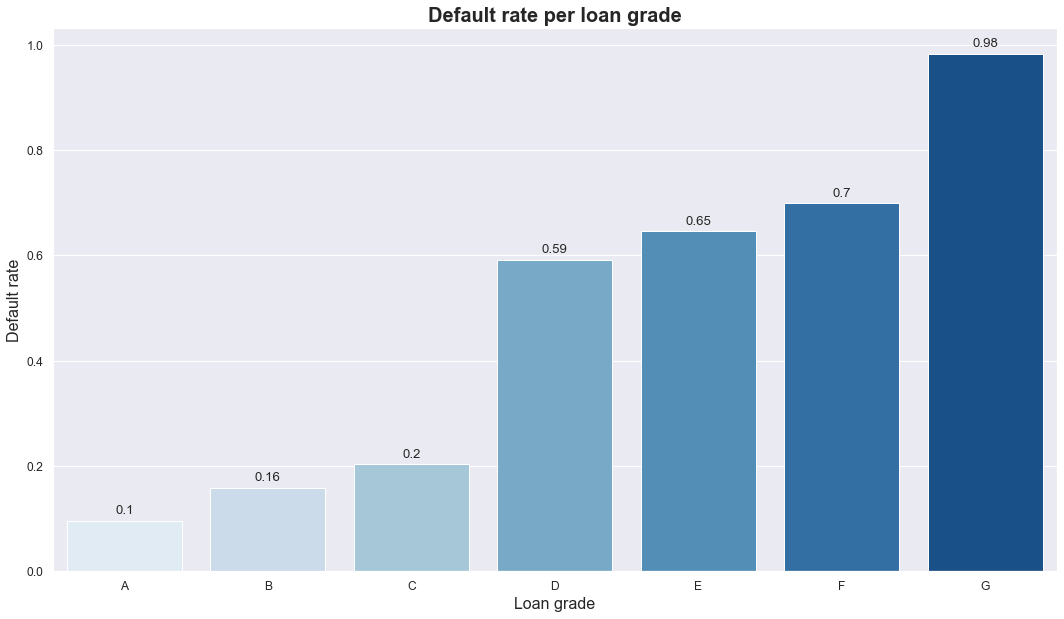

In [395]:
# # Plot the calibration distribution
# pd_calibration.plot(\
#     x="loan_grade",
#     y="default_rate",
#     kind="bar",
#     figsize=(18,10)
# )
                    # xlabel="Loan grade",
                    # ylabel="Calibrated probability of default",
                    # title="Bella")

# Calculate the value
# df_int_rate_grade = df_analysis.groupby(["loan_grade"]).mean().reset_index()

# Define histogram
# Define graph options
plot_args = {
    "df": pd_calibration,
    "x": "loan_grade",
    "y": "default_rate", 
    "hue" : "",
    "plot_options": {
        "kind": "bar",
        "title": "Default rate per loan grade",
        "x_label": "Loan grade",
        "y_label": "Default rate",
        "palette": "Blues",
        "fig_size": (18,10),
    }
}


# Plot
sns_multivariate(plot_args)

# Error variance within each loan grade based on optimal model estimates